Note: The dataset files (train.txt, val.txt, test.txt) and the Glove model files (glove.6B.100d.txt, glove.6B.100d.word2vec.txt) should be in the same folder as the notebook script

In [ ]:
# install necessary libraries
!pip install nltk
!pip install pandas
!pip install tabulate
!pip install wordcloud
!pip install matplotlib
!pip install gensim
!pip install scikit-learn
!pip install empath
!pip install transformers

In [ ]:
# import necessary functions
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
# Make sure to download required NLTK resources if not already done
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 1

## Constructing dataframe of each emotion

In [ ]:
import pandas as pd

# Load the dataset from a file
train_file_path = 'train.txt'

# Read the dataset and split it based on the delimiter ';'
data = []
with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        sentence, emotion = line.strip().split(';')
        data.append((sentence, emotion))

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Sentence', 'Emotion'])

# Create a dictionary to store DataFrames for each emotion category
emotion_dfs = {}

# Iterate through unique emotions and create separate DataFrames
for emotion in df['Emotion'].unique():
    emotion_dfs[emotion] = df[df['Emotion'] == emotion].reset_index(drop=True)

# Example of accessing the DataFrame for a specific emotion
print(emotion_dfs['sadness'].head())

                                            Sentence  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2  ive been feeling a little burdened lately wasn...  sadness
3  i feel like i have to make the suffering i m s...  sadness
4                 i feel low energy i m just thirsty  sadness


Getting the:
-  vocabulary set of each dataframe
- the proportion of unique tokens
- the average number of tokens per post
- the average number of pronouns per post
- the average number of out-of-vocabulary tokens

In [ ]:
df.head()

,Sentence,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
# Function to tokenize text and clean tokens
def tokenize_text(text):
    tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    tokens = [token for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    return tokens

# Function to identify out-of-vocabulary tokens (not in WordNet)
def is_oov(token):
    return wordnet.synsets(token) == []

# Function to calculate statistics for each emotion DataFrame
def analyze_emotion_df(emotion_df):
    vocab = set()  # Vocabulary for the category
    all_tokens = []  # List to store all tokens for average token calculation
    all_pronouns = []  # List to store pronoun counts
    all_oov_tokens = []  # List to store OOV counts

    # Define pronoun tags
    pronoun_tags = {'PRP', 'PRP$', 'WP', 'WP$'}

    for sentence in emotion_df['Sentence']:
        tokens = tokenize_text(sentence)
        vocab.update(tokens)  # Add tokens to vocabulary
        all_tokens.append(len(tokens))  # Track number of tokens per post

        # POS tagging to identify pronouns
        pos_tags = pos_tag(tokens)
        pronouns = [word for word, tag in pos_tags if tag in pronoun_tags]
        all_pronouns.append(len(pronouns))  # Track number of pronouns per post

        # Identify out-of-vocabulary tokens
        oov_tokens = [token for token in tokens if is_oov(token)]
        all_oov_tokens.append(len(oov_tokens))  # Track number of OOV tokens per post

    # Calculate statistics
    avg_tokens = np.mean(all_tokens)
    std_tokens = np.std(all_tokens)
    avg_pronouns = np.mean(all_pronouns)
    std_pronouns = np.std(all_pronouns)
    avg_oov = np.mean(all_oov_tokens)
    std_oov = np.std(all_oov_tokens)

    return {
        'vocab': vocab,
        'avg_tokens': avg_tokens,
        'std_tokens': std_tokens,
        'avg_pronouns': avg_pronouns,
        'std_pronouns': std_pronouns,
        'avg_oov': avg_oov,
        'std_oov': std_oov
    }

# Create a dictionary to hold the analysis result for each emotion category
emotion_analysis = {}

# Analyze each emotion DataFrame
for emotion, emotion_df in emotion_dfs.items():
    analysis = analyze_emotion_df(emotion_df)
    emotion_analysis[emotion] = analysis

# Calculate the proportion of unique tokens for each category
# Step 1: Combine vocabularies across all emotions to identify unique tokens
all_vocabs = {emotion: analysis['vocab'] for emotion, analysis in emotion_analysis.items()}
combined_vocab = set().union(*all_vocabs.values())

# Step 2: Identify unique tokens per category (tokens that do not appear in other categories)
for emotion, vocab in all_vocabs.items():
    other_vocabs = set().union(*(v for e, v in all_vocabs.items() if e != emotion))
    unique_tokens = vocab - other_vocabs
    unique_proportion = len(unique_tokens) / len(vocab) if len(vocab) > 0 else 0
    emotion_analysis[emotion]['unique_proportion'] = unique_proportion

# Print the results for each emotion
for emotion, stats in emotion_analysis.items():
    print(f"Emotion: {emotion}")
    print(f"  Vocabulary Size: {len(stats['vocab'])}")
    print(f"  Proportion of Unique Tokens: {stats['unique_proportion']:.2f}")
    print(f"  Average Number of Tokens per Post: {stats['avg_tokens']:.2f} (Std: {stats['std_tokens']:.2f})")
    print(f"  Average Number of Pronouns per Post: {stats['avg_pronouns']:.2f} (Std: {stats['std_pronouns']:.2f})")
    print(f"  Average Number of Out-of-Vocabulary Tokens per Post: {stats['avg_oov']:.2f} (Std: {stats['std_oov']:.2f})")
    print("\n")

Emotion: sadness
  Vocabulary Size: 7008
  Proportion of Unique Tokens: 0.30
  Average Number of Tokens per Post: 18.37 (Std: 11.04)
  Average Number of Pronouns per Post: 1.14 (Std: 1.43)
  Average Number of Out-of-Vocabulary Tokens per Post: 4.39 (Std: 3.56)


Emotion: anger
  Vocabulary Size: 4812
  Proportion of Unique Tokens: 0.24
  Average Number of Tokens per Post: 19.24 (Std: 11.43)
  Average Number of Pronouns per Post: 1.30 (Std: 1.55)
  Average Number of Out-of-Vocabulary Tokens per Post: 4.76 (Std: 3.74)


Emotion: love
  Vocabulary Size: 3839
  Proportion of Unique Tokens: 0.21
  Average Number of Tokens per Post: 20.71 (Std: 10.83)
  Average Number of Pronouns per Post: 1.56 (Std: 1.65)
  Average Number of Out-of-Vocabulary Tokens per Post: 5.48 (Std: 3.78)


Emotion: surprise
  Vocabulary Size: 2168
  Proportion of Unique Tokens: 0.14
  Average Number of Tokens per Post: 19.98 (Std: 11.04)
  Average Number of Pronouns per Post: 1.32 (Std: 1.51)
  Average Number of Out-of

## Summarizing the above results in a table

In [ ]:
from tabulate import tabulate

# Prepare the data for the summary table
summary_data = []

for emotion, stats in emotion_analysis.items():
    summary_data.append([
        emotion.capitalize(),
        len(stats['vocab']),
        f"{stats['unique_proportion']:.2f}",
        f"{stats['avg_tokens']:.2f}",
        f"{stats['std_tokens']:.2f}",
        f"{stats['avg_pronouns']:.2f}",
        f"{stats['std_pronouns']:.2f}",
        f"{stats['avg_oov']:.2f}",
        f"{stats['std_oov']:.2f}"
    ])

# Define headers for the table
headers = [
    "Emotion",
    "Vocab Size",
    "Unique Token Proportion",
    "Avg Tokens per Post",
    "Std Tokens",
    "Avg Pronouns per Post",
    "Std Pronouns",
    "Avg OOV Tokens per Post",
    "Std OOV Tokens"
]

# Generate a pretty table using tabulate
print(tabulate(summary_data, headers=headers, tablefmt="fancy_grid"))

╒═══════════╤══════════════╤═══════════════════════════╤═══════════════════════╤══════════════╤═════════════════════════╤════════════════╤═══════════════════════════╤══════════════════╕
│ Emotion   │   Vocab Size │   Unique Token Proportion │   Avg Tokens per Post │   Std Tokens │   Avg Pronouns per Post │   Std Pronouns │   Avg OOV Tokens per Post │   Std OOV Tokens │
╞═══════════╪══════════════╪═══════════════════════════╪═══════════════════════╪══════════════╪═════════════════════════╪════════════════╪═══════════════════════════╪══════════════════╡
│ Sadness   │         7008 │                      0.3  │                 18.37 │        11.04 │                    1.14 │           1.43 │                      4.39 │             3.56 │
├───────────┼──────────────┼───────────────────────────┼───────────────────────┼──────────────┼─────────────────────────┼────────────────┼───────────────────────────┼──────────────────┤
│ Anger     │         4812 │                      0.24 │              

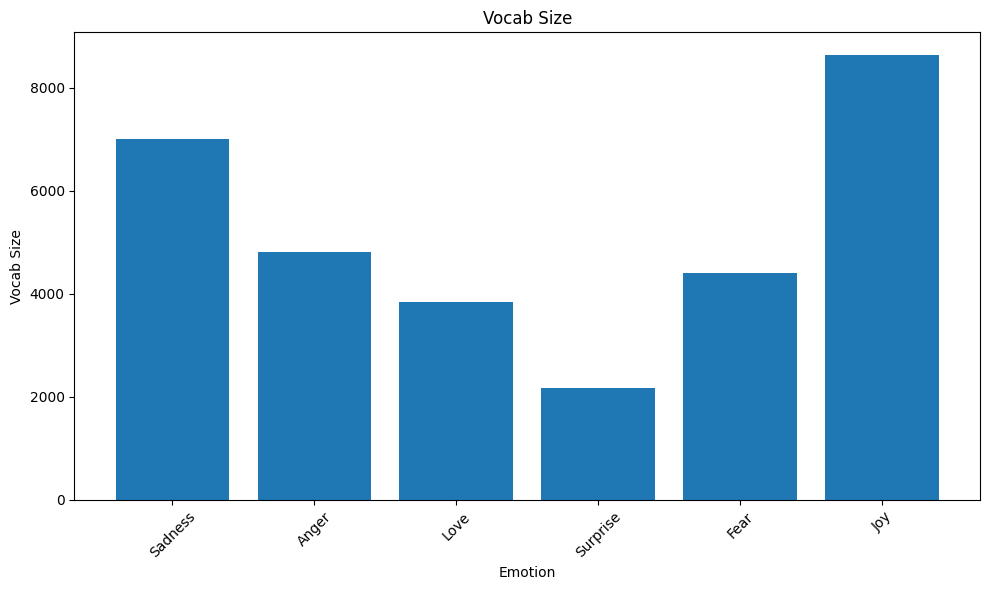

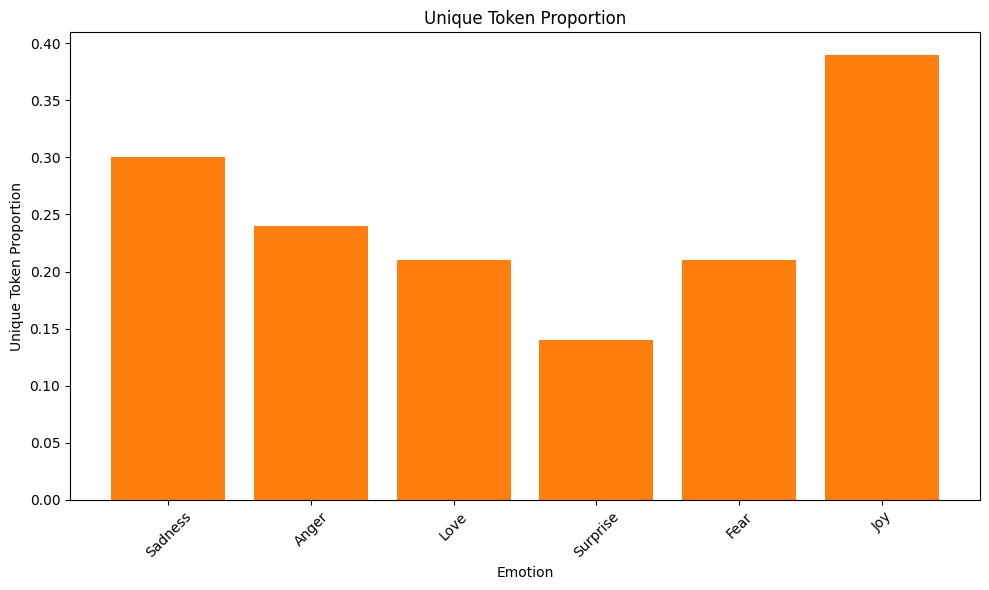

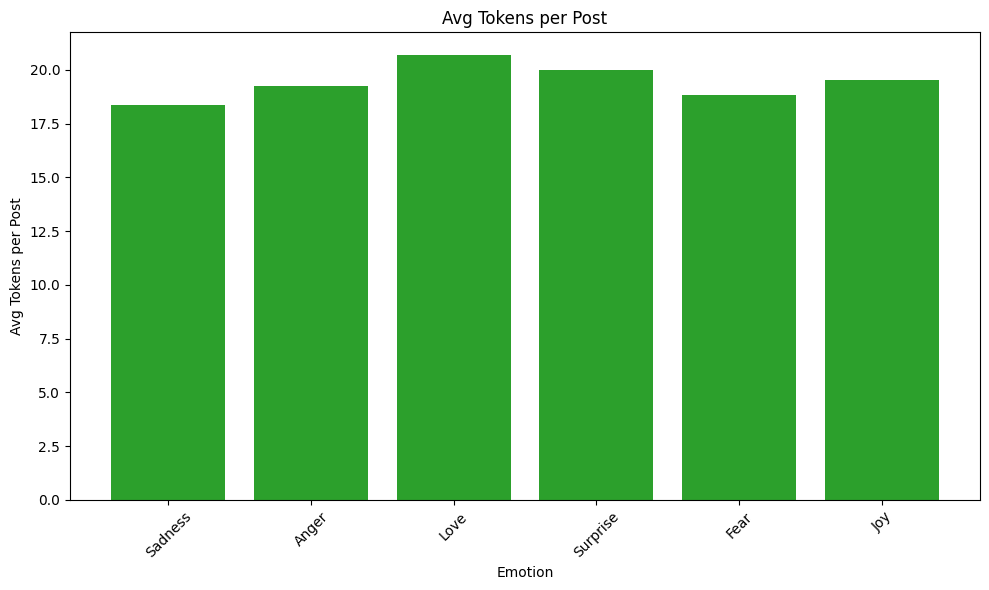

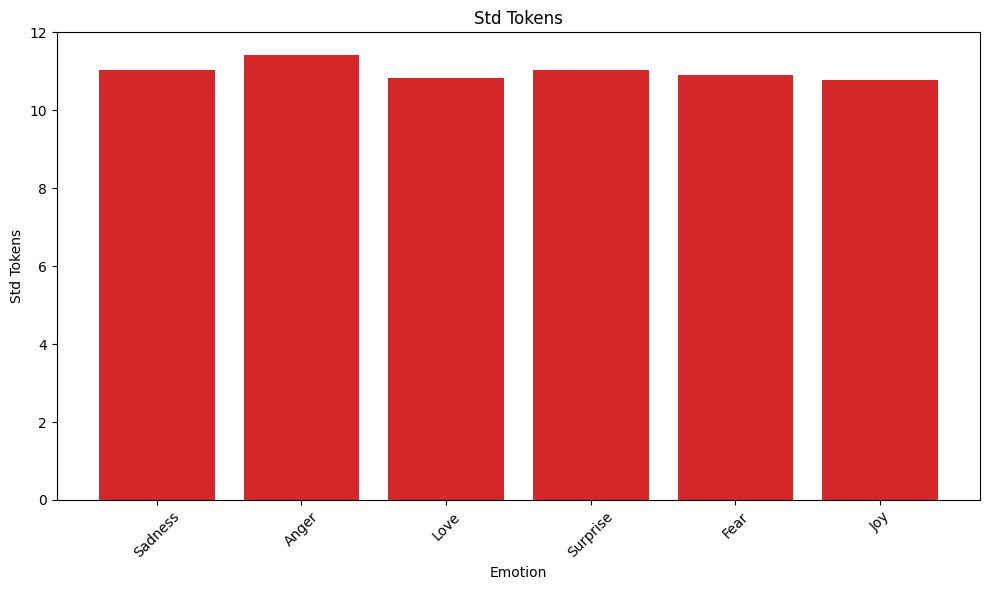

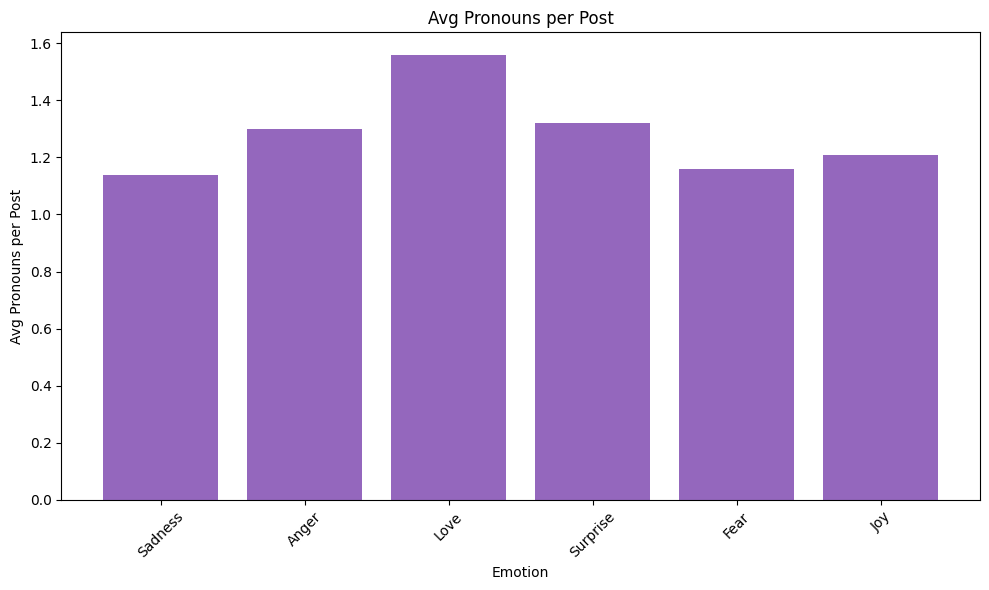

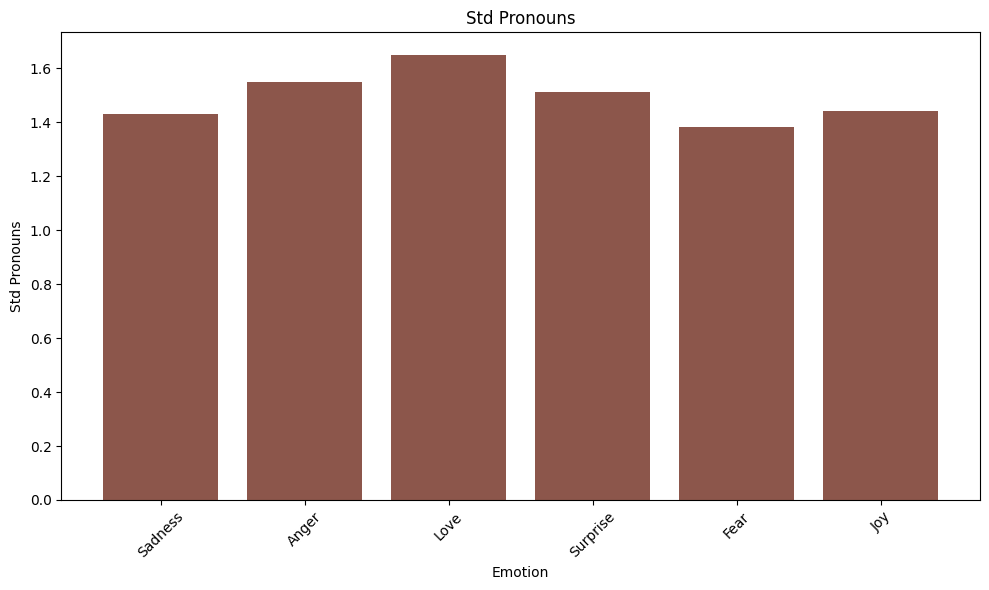

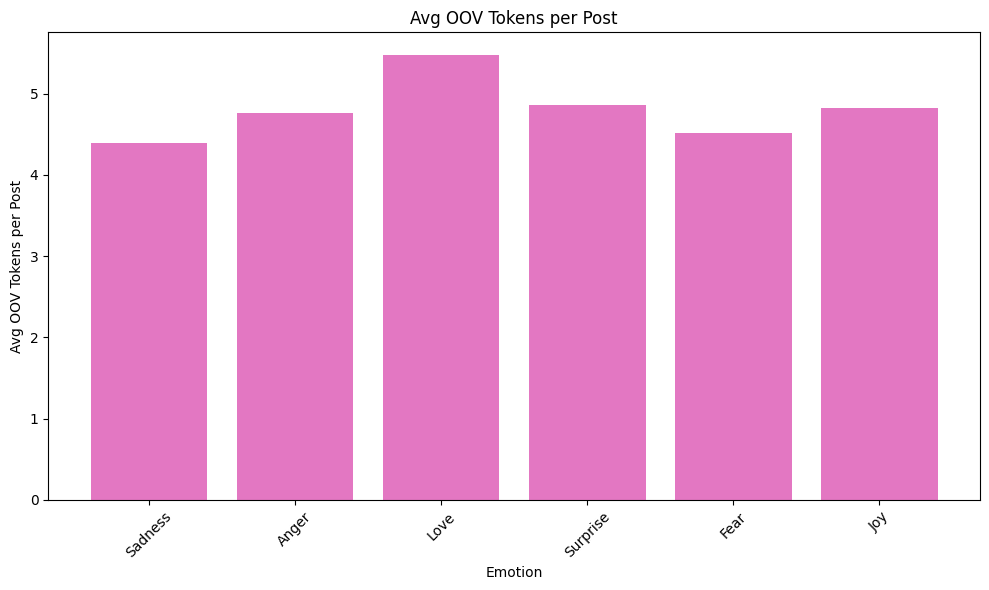

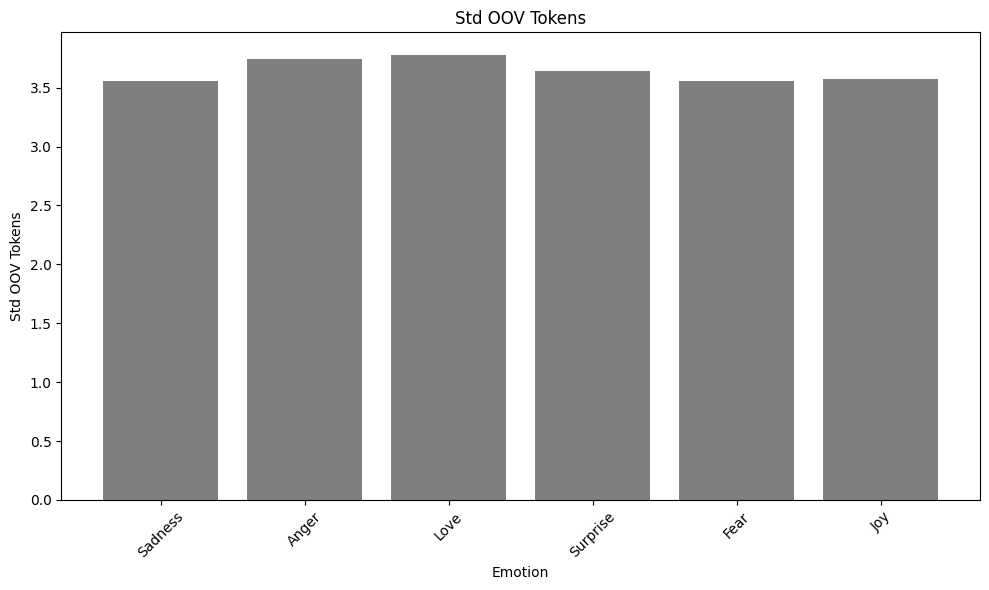

In [ ]:
# Plotting the table values in bar diagram

import matplotlib.pyplot as plt
import numpy as np

# Extract each column for plotting
emotions = [row[0] for row in summary_data]
vocab_sizes = [row[1] for row in summary_data]
unique_proportions = [float(row[2]) for row in summary_data]
avg_tokens = [float(row[3]) for row in summary_data]
std_tokens = [float(row[4]) for row in summary_data]
avg_pronouns = [float(row[5]) for row in summary_data]
std_pronouns = [float(row[6]) for row in summary_data]
avg_oov = [float(row[7]) for row in summary_data]
std_oov = [float(row[8]) for row in summary_data]

# Define data and labels for each plot
data = {
    "Vocab Size": vocab_sizes,
    "Unique Token Proportion": unique_proportions,
    "Avg Tokens per Post": avg_tokens,
    "Std Tokens": std_tokens,
    "Avg Pronouns per Post": avg_pronouns,
    "Std Pronouns": std_pronouns,
    "Avg OOV Tokens per Post": avg_oov,
    "Std OOV Tokens": std_oov
}

# Define colors for each metric plot
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

# Plot each data column as a separate bar plot with different colors
for (label, values), color in zip(data.items(), colors):
    plt.figure(figsize=(10, 6))
    plt.bar(emotions, values, color=color)
    plt.title(label)
    plt.xlabel("Emotion")
    plt.ylabel(label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


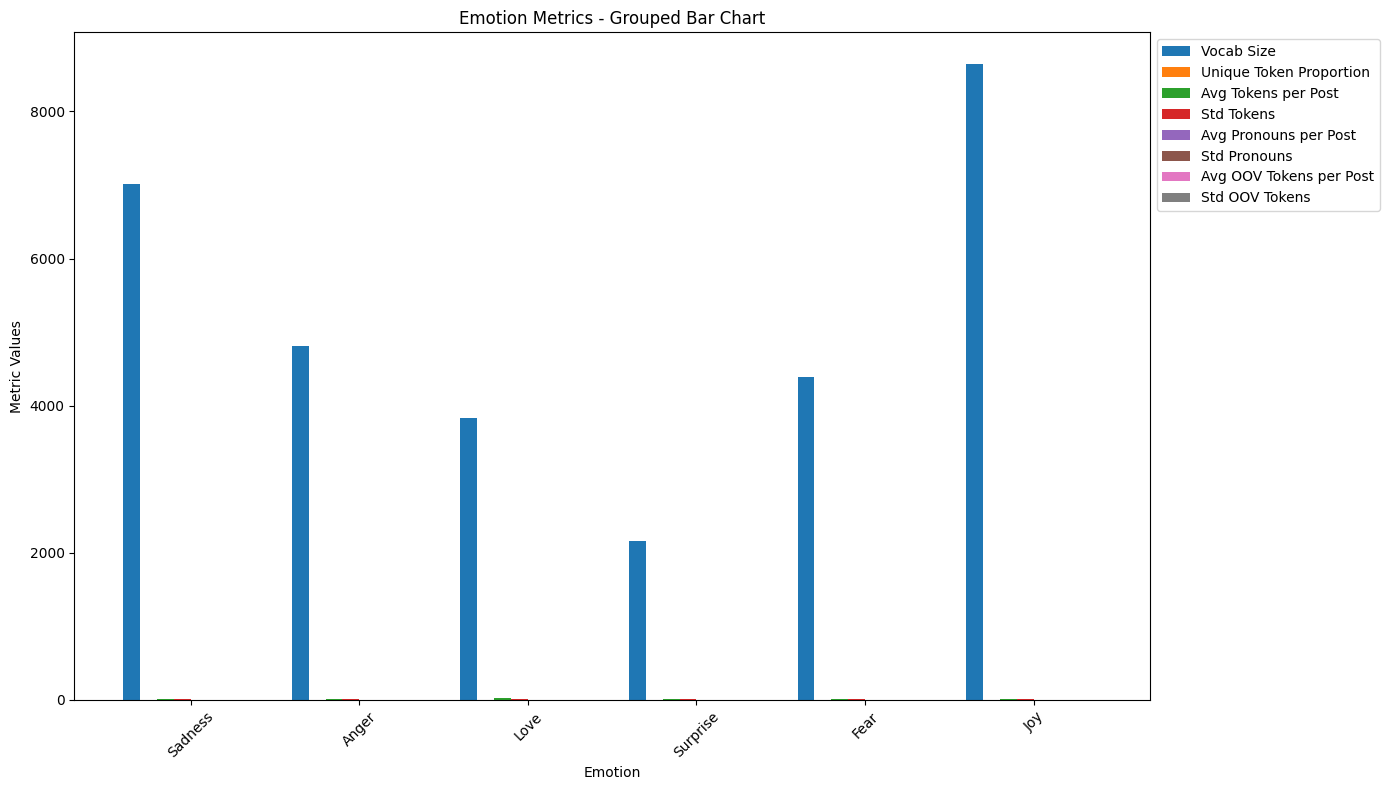

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
emotions = [row[0] for row in summary_data]
vocab_sizes = np.array([row[1] for row in summary_data])
unique_proportions = np.array([float(row[2]) for row in summary_data])
avg_tokens = np.array([float(row[3]) for row in summary_data])
std_tokens = np.array([float(row[4]) for row in summary_data])
avg_pronouns = np.array([float(row[5]) for row in summary_data])
std_pronouns = np.array([float(row[6]) for row in summary_data])
avg_oov = np.array([float(row[7]) for row in summary_data])
std_oov = np.array([float(row[8]) for row in summary_data])

# Define the width of each individual bar
bar_width = 0.1

# Number of metrics for each emotion
num_metrics = 8
indices = np.arange(len(emotions))

# Define color map and labels for each metric
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]
labels = [
    "Vocab Size", "Unique Token Proportion", "Avg Tokens per Post", "Std Tokens",
    "Avg Pronouns per Post", "Std Pronouns", "Avg OOV Tokens per Post", "Std OOV Tokens"
]

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each metric as a separate bar within each emotion group
for i, (column, color, label) in enumerate(zip([vocab_sizes, unique_proportions, avg_tokens, std_tokens, avg_pronouns, std_pronouns, avg_oov, std_oov], colors, labels)):
    # Offset each metric within the group
    ax.bar(indices + i * bar_width, column, bar_width, color=color, label=label)

# Labeling and legend
ax.set_xlabel("Emotion")
ax.set_ylabel("Metric Values")
ax.set_title("Emotion Metrics - Grouped Bar Chart")
ax.set_xticks(indices + bar_width * (num_metrics - 1) / 2)
ax.set_xticklabels(emotions, rotation=45)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Place legend outside the plot
plt.tight_layout()

# Show plot
plt.show()


# 2:

## 2.1:
## wordcloud illustration of each emotion

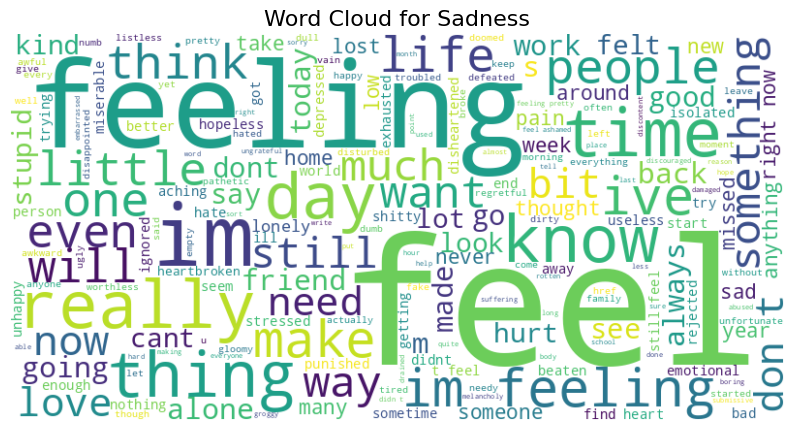

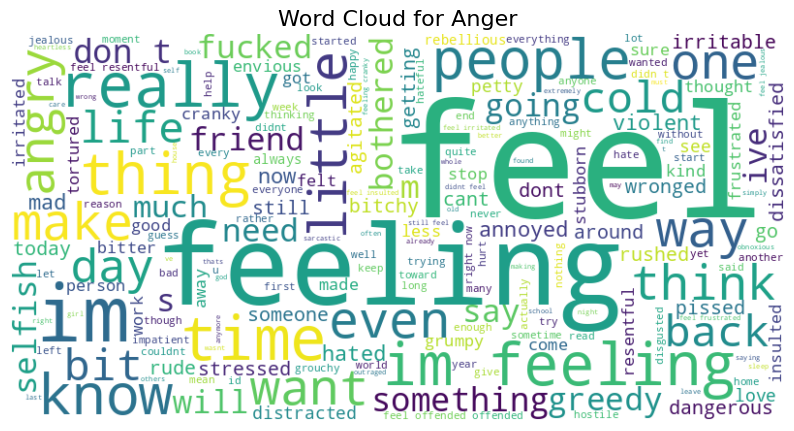

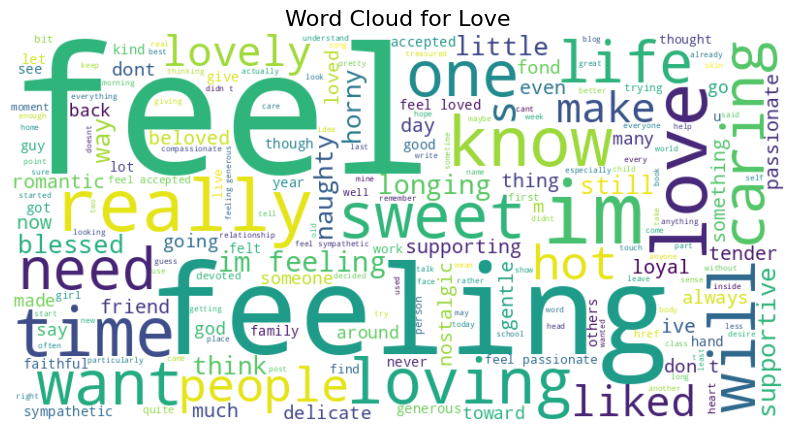

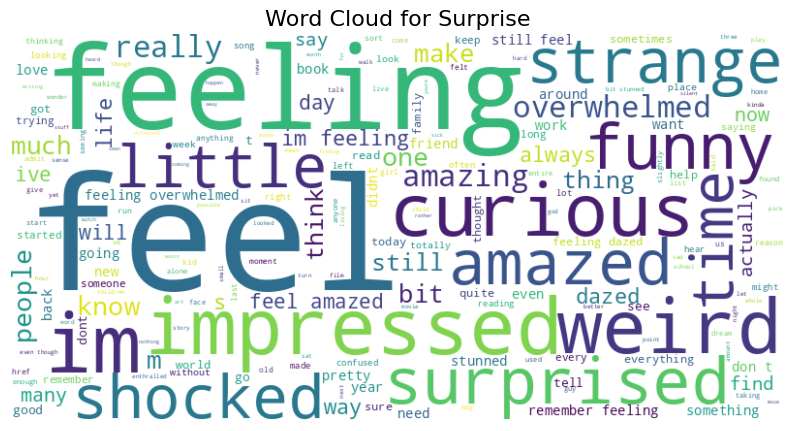

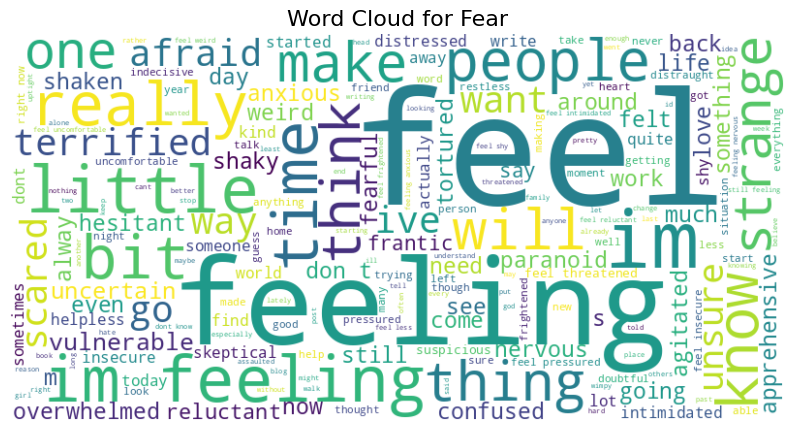

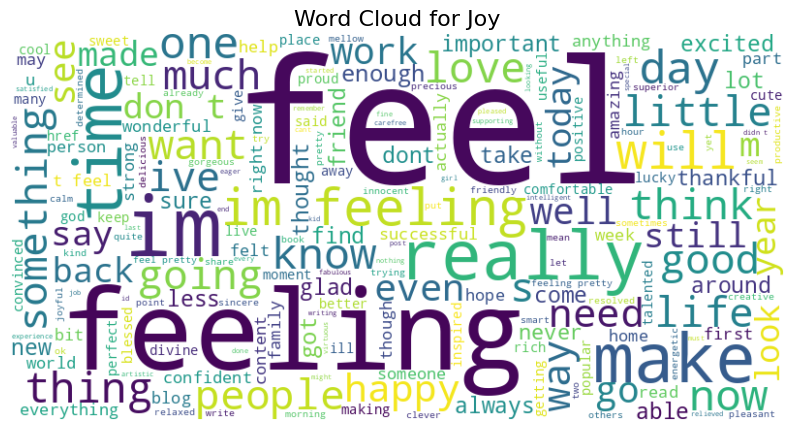

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a word cloud for a given DataFrame
def generate_wordcloud(emotion, emotion_df):
    # Combine all sentences into a single string
    text = " ".join(sentence for sentence in emotion_df['Sentence'])

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # Plot the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {emotion.capitalize()}", fontsize=16)
    plt.show()

# Generate word clouds for each emotion
for emotion, emotion_df in emotion_dfs.items():
    generate_wordcloud(emotion, emotion_df)
    print()

## 2.2
##  identifying top 20 frequent tokens of each category (excluding stopwords)

In [ ]:
from nltk.corpus import stopwords
from collections import Counter

# Get the list of stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to get the top 20 most frequent tokens, excluding stopwords
def get_top_tokens(emotion, emotion_df):
    # Combine all sentences into a single string and tokenize
    all_tokens = []
    for sentence in emotion_df['Sentence']:
        tokens = tokenize_text(sentence)  # Reuse the `tokenize_text` function from previous examples
        # Filter out stopwords and add to list
        filtered_tokens = [token for token in tokens if token not in stop_words]
        all_tokens.extend(filtered_tokens)

    # Count the frequency of each token
    token_counts = Counter(all_tokens)

    # Get the 20 most common tokens
    top_20_tokens = token_counts.most_common(20)

    return top_20_tokens

# Iterate over each emotion and print the top 20 tokens
for emotion, emotion_df in emotion_dfs.items():
    top_tokens = get_top_tokens(emotion, emotion_df)
    print(f"Top 20 Tokens for {emotion.capitalize()}:")
    for token, freq in top_tokens:
        print(f"{token}: {freq}")
    print("\n")

Top 20 Tokens for Sadness:
feel: 3299
feeling: 1523
like: 864
im: 683
really: 276
know: 275
get: 225
ive: 217
would: 203
still: 200
time: 199
little: 194
even: 186
want: 179
people: 176
life: 176
think: 175
one: 172
bit: 169
dont: 158


Top 20 Tokens for Anger:
feel: 1459
feeling: 721
like: 384
im: 342
really: 124
get: 121
time: 118
know: 115
little: 105
people: 105
want: 98
even: 95
would: 89
angry: 85
way: 85
think: 81
things: 80
one: 79
could: 79
bit: 77


Top 20 Tokens for Love:
feel: 929
feeling: 378
like: 306
im: 193
love: 97
really: 92
know: 79
sweet: 69
loving: 68
time: 68
want: 65
one: 64
passionate: 63
caring: 62
life: 56
little: 55
sympathetic: 55
hot: 55
lovely: 55
feelings: 55


Top 20 Tokens for Surprise:
feel: 356
feeling: 209
im: 91
like: 90
amazed: 67
impressed: 61
overwhelmed: 58
weird: 57
surprised: 55
curious: 54
funny: 49
strange: 45
shocked: 45
little: 44
really: 41
amazing: 40
still: 39
time: 36
dazed: 32
bit: 30


Top 20 Tokens for Fear:
feel: 1212
feeling: 742


In [ ]:
from nltk.corpus import stopwords
from collections import Counter

# Get the list of stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to get the top 20 most frequent tokens, excluding stopwords
def get_top_tokens(emotion, emotion_df):
    # Combine all sentences into a single string and tokenize
    all_tokens = []
    for sentence in emotion_df['Sentence']:
        tokens = tokenize_text(sentence)  # Reuse the `tokenize_text` function from previous examples
        # Filter out stopwords and add to list
        filtered_tokens = [token for token in tokens if token not in stop_words]
        all_tokens.extend(filtered_tokens)

    # Count the frequency of each token
    token_counts = Counter(all_tokens)

    # Get the 20 most common tokens
    top_20_tokens = token_counts.most_common(20)

    return top_20_tokens

# Iterate over each emotion and print the top 20 tokens
for emotion, emotion_df in emotion_dfs.items():
    top_tokens = get_top_tokens(emotion, emotion_df)
    print(f"Top 20 Tokens for {emotion.capitalize()}:")
    for token, freq in top_tokens:
        print(f"{token}: {freq}")
    print("\n")

Top 20 Tokens for Sadness:
feel: 3299
feeling: 1523
like: 864
im: 683
really: 276
know: 275
get: 225
ive: 217
would: 203
still: 200
time: 199
little: 194
even: 186
want: 179
people: 176
life: 176
think: 175
one: 172
bit: 169
dont: 158


Top 20 Tokens for Anger:
feel: 1459
feeling: 721
like: 384
im: 342
really: 124
get: 121
time: 118
know: 115
little: 105
people: 105
want: 98
even: 95
would: 89
angry: 85
way: 85
think: 81
things: 80
one: 79
could: 79
bit: 77


Top 20 Tokens for Love:
feel: 929
feeling: 378
like: 306
im: 193
love: 97
really: 92
know: 79
sweet: 69
loving: 68
time: 68
want: 65
one: 64
passionate: 63
caring: 62
life: 56
little: 55
sympathetic: 55
hot: 55
lovely: 55
feelings: 55


Top 20 Tokens for Surprise:
feel: 356
feeling: 209
im: 91
like: 90
amazed: 67
impressed: 61
overwhelmed: 58
weird: 57
surprised: 55
curious: 54
funny: 49
strange: 45
shocked: 45
little: 44
really: 41
amazing: 40
still: 39
time: 36
dazed: 32
bit: 30


Top 20 Tokens for Fear:
feel: 1212
feeling: 742


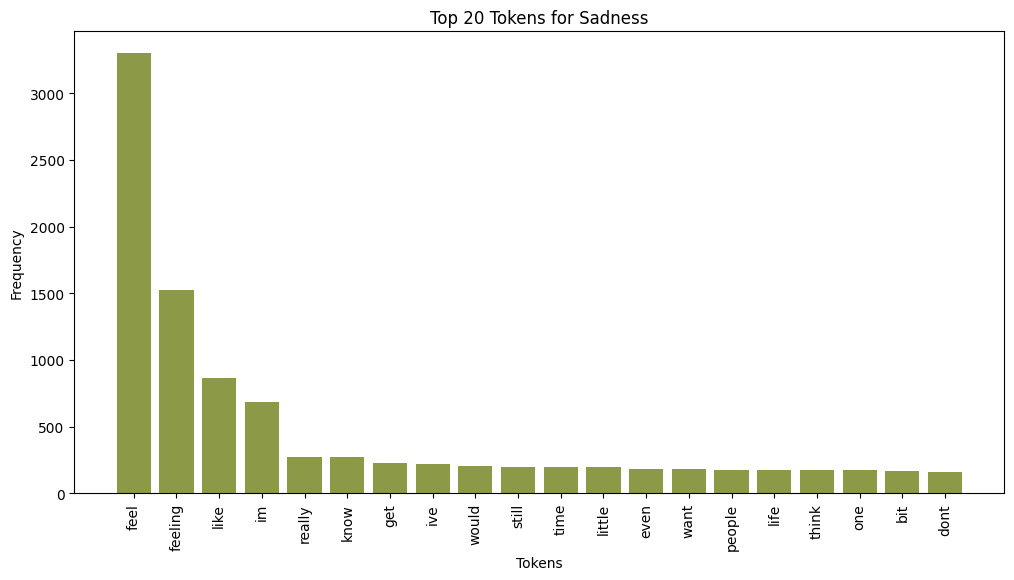

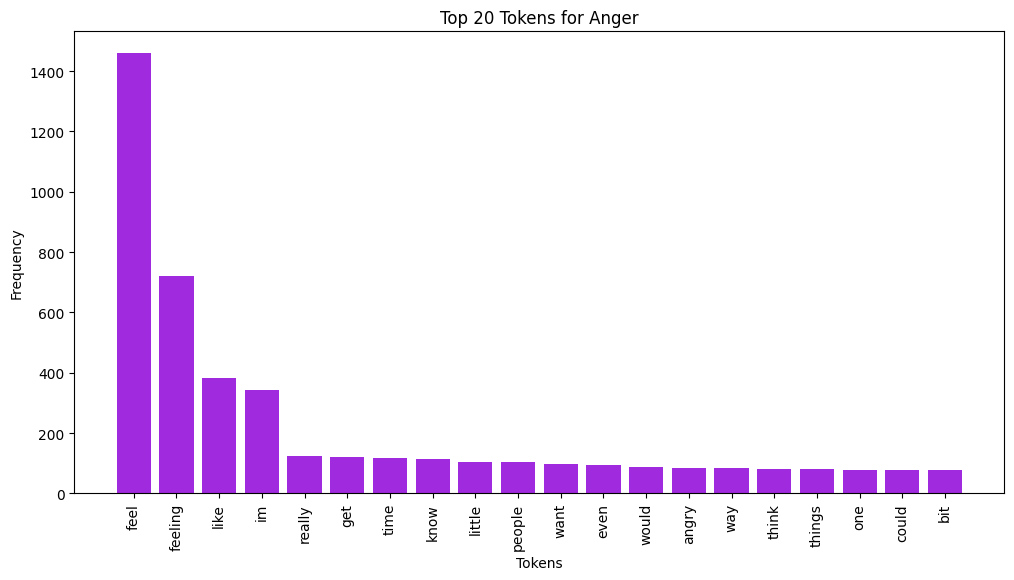

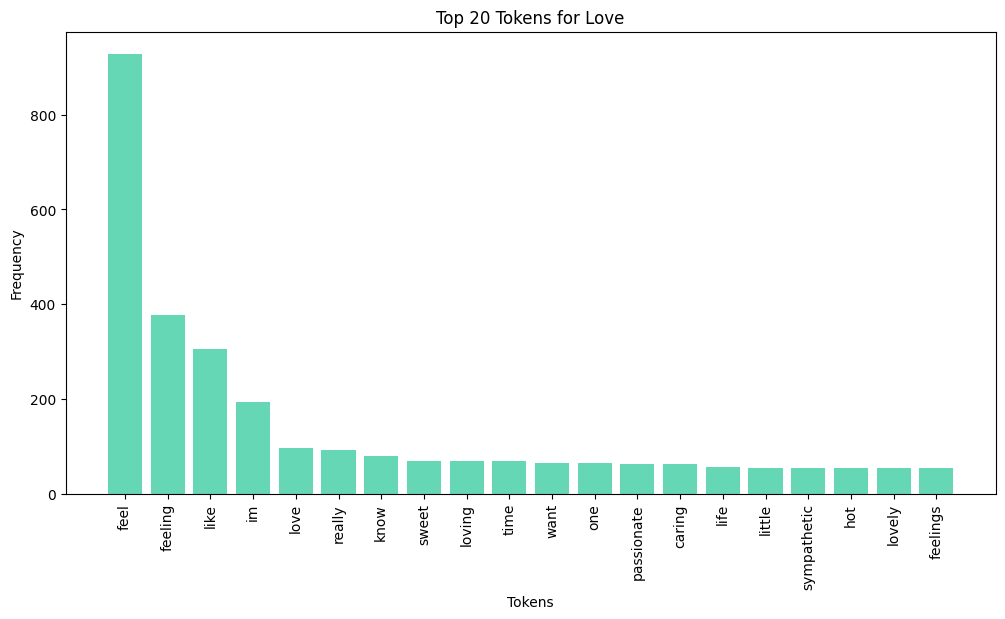

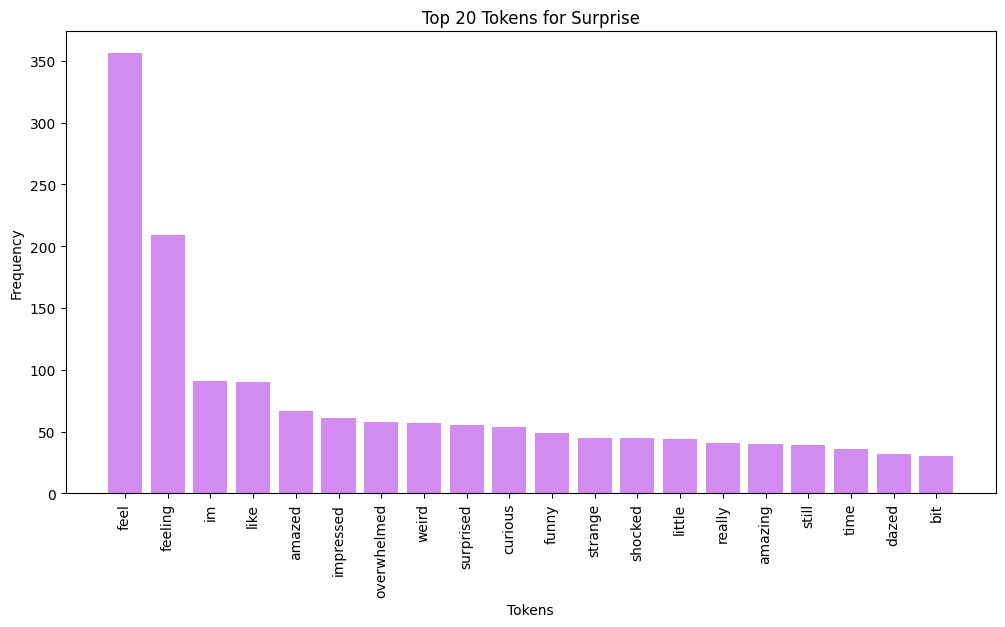

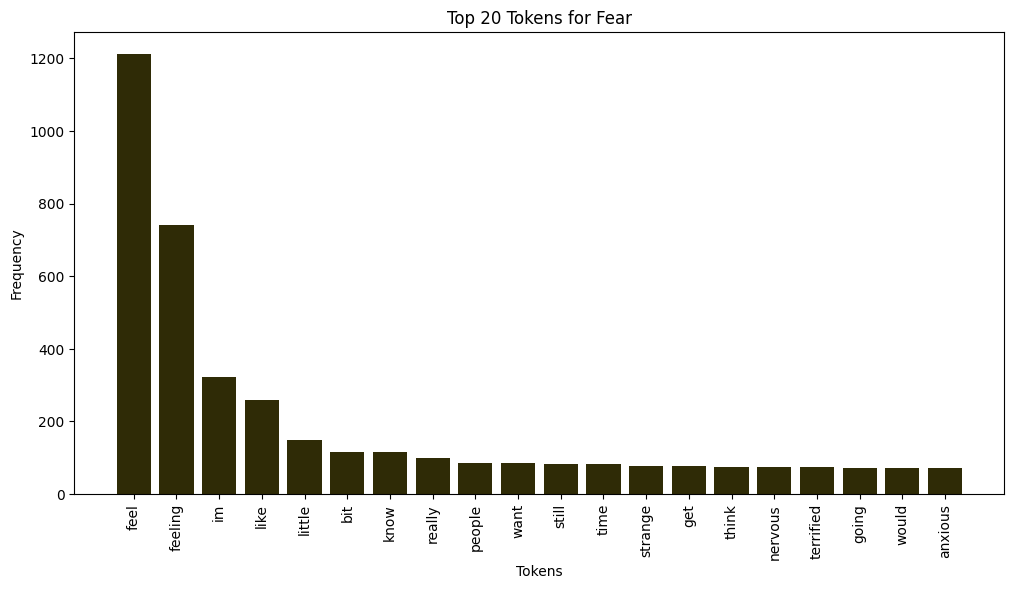

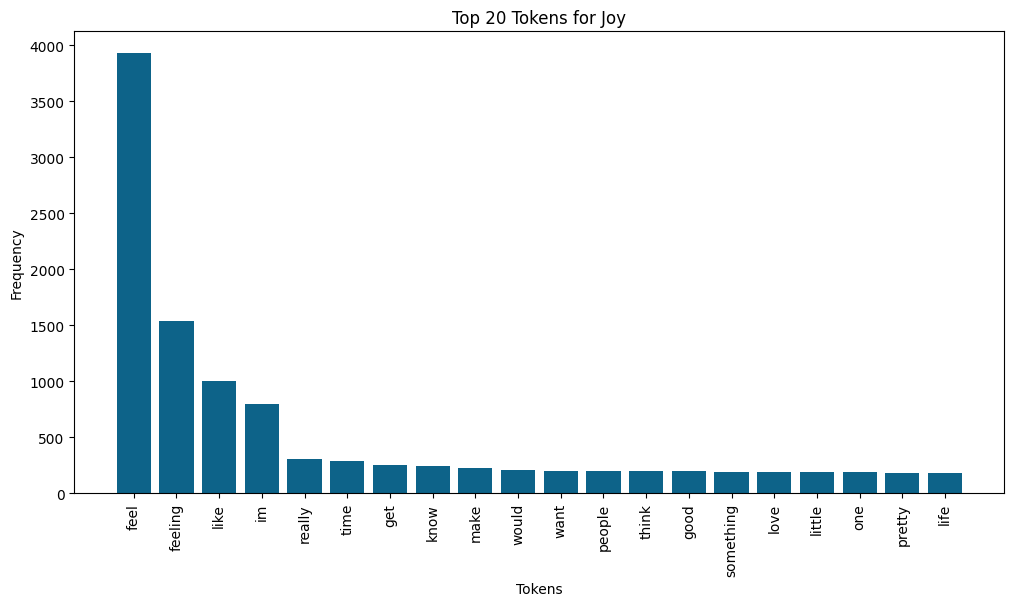

In [ ]:
import matplotlib.pyplot as plt
import random

# Function to plot bar chart for top 20 tokens
def plot_top_tokens(emotion, top_tokens, color):
    # Extract tokens and their frequencies
    tokens, freqs = zip(*top_tokens)

    # Create a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(tokens, freqs, color=color)
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Tokens for {emotion.capitalize()}')
    plt.xticks(rotation=90)  # Rotate token names for better readability
    plt.show()

# Generate a random color for each emotion plot
def generate_color():
    return f"#{random.randint(0, 0xFFFFFF):06x}"

# Iterate over each emotion and plot the top 20 tokens with a unique color
for emotion, emotion_df in emotion_dfs.items():
    top_tokens = get_top_tokens(emotion, emotion_df)
    color = generate_color()  # Get a unique color for each emotion
    plot_top_tokens(emotion, top_tokens, color)


## 2.3
## constructing a vocabulary of these top 20 frequent tokens

In [ ]:
# Create a set to store the vocabulary of top tokens across all categories
vocabulary_set = set()

# Function to get the top 20 most frequent tokens, excluding stopwords
def get_top_tokens(emotion, emotion_df):
    # Combine all sentences into a single string and tokenize
    all_tokens = []
    for sentence in emotion_df['Sentence']:
        tokens = tokenize_text(sentence)  # Reuse the `tokenize_text` function from previous examples
        # Filter out stopwords and add to list
        filtered_tokens = [token for token in tokens if token not in stop_words]
        all_tokens.extend(filtered_tokens)

    # Count the frequency of each token
    token_counts = Counter(all_tokens)

    # Get the 20 most common tokens
    top_20_tokens = token_counts.most_common(20)

    return [token for token, freq in top_20_tokens]

# Iterate over each emotion and collect the top 20 tokens into the vocabulary set
for emotion, emotion_df in emotion_dfs.items():
    top_tokens = get_top_tokens(emotion, emotion_df)
    vocabulary_set.update(top_tokens)

# Display the final vocabulary set
print("Vocabulary of Top Tokens Over All Categories:")
print(sorted(vocabulary_set))

Vocabulary of Top Tokens Over All Categories:
['amazed', 'amazing', 'angry', 'anxious', 'bit', 'caring', 'could', 'curious', 'dazed', 'dont', 'even', 'feel', 'feeling', 'feelings', 'funny', 'get', 'going', 'good', 'hot', 'im', 'impressed', 'ive', 'know', 'life', 'like', 'little', 'love', 'lovely', 'loving', 'make', 'nervous', 'one', 'overwhelmed', 'passionate', 'people', 'pretty', 'really', 'shocked', 'something', 'still', 'strange', 'surprised', 'sweet', 'sympathetic', 'terrified', 'things', 'think', 'time', 'want', 'way', 'weird', 'would']


In [ ]:
############ 2.4 without plotting


# import pandas as pd
# import numpy as np
# from scipy.stats import pearsonr

# # Step 1: Prepare a DataFrame to hold the token frequencies for each category
# token_vocabulary = sorted(vocabulary_set)  # Sorted list of top tokens for consistent order
# frequency_matrix = pd.DataFrame(0, index=emotion_dfs.keys(), columns=token_vocabulary)

# # Step 2: Fill the frequency matrix
# for emotion, emotion_df in emotion_dfs.items():
#     # Get top tokens for the emotion
#     top_tokens = get_top_tokens(emotion, emotion_df)
#     # Count frequencies for the top tokens in the current emotion
#     all_tokens = []
#     for sentence in emotion_df['Sentence']:
#         tokens = tokenize_text(sentence)  # Reuse the `tokenize_text` function from previous examples
#         filtered_tokens = [token for token in tokens if token not in stop_words]
#         all_tokens.extend(filtered_tokens)

#     token_counts = Counter(all_tokens)

#     # Fill the frequency matrix for the current emotion
#     for token in top_tokens:
#         frequency_matrix.loc[emotion, token] = token_counts[token]

# # Step 3: Calculate Pearson correlation coefficients
# correlation_matrix = pd.DataFrame(index=emotion_dfs.keys(), columns=emotion_dfs.keys())

# for emotion1 in emotion_dfs.keys():
#     for emotion2 in emotion_dfs.keys():
#         if emotion1 != emotion2:
#             corr, _ = pearsonr(frequency_matrix.loc[emotion1], frequency_matrix.loc[emotion2])
#             correlation_matrix.loc[emotion1, emotion2] = corr

# # Step 4: Display the correlation matrix
# correlation_matrix.fillna(1, inplace=True)  # Diagonal elements should be 1 as self-correlation
# print("Pearson Correlation Coefficient Matrix:")
# print(correlation_matrix)


## 2.4
##  Estimating the Pearson correlation coefficient of every pair of categories

(Assuming the vector of each category is the frequency of vocabulary tokens)

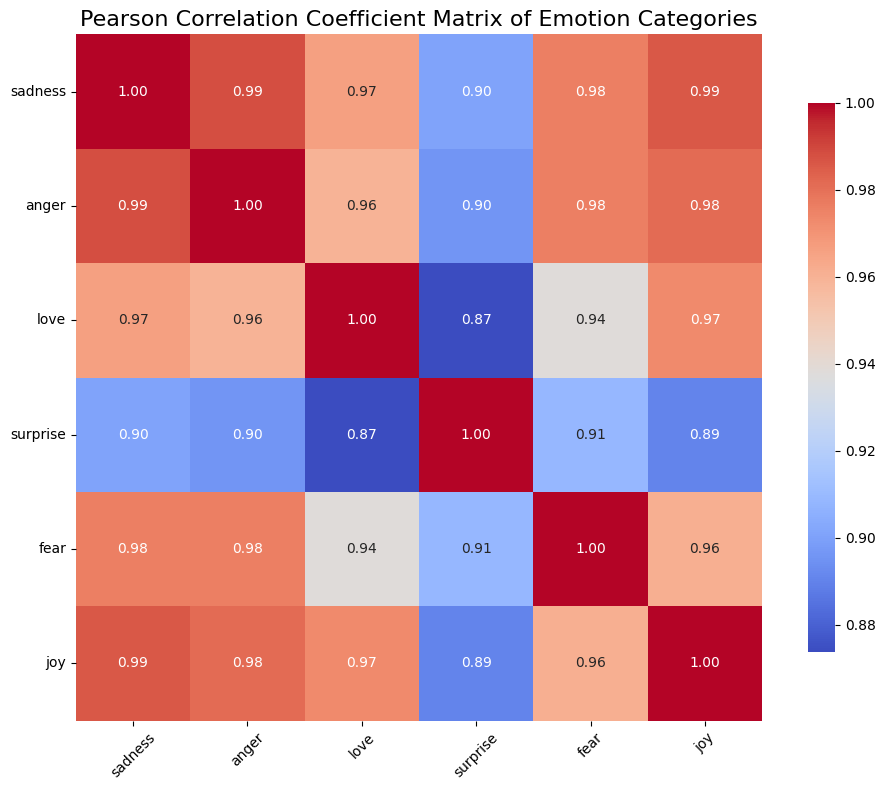


Pearson Correlation Coefficient Matrix:
           sadness     anger      love  surprise      fear       joy
sadness   1.000000  0.988573  0.966050  0.900743  0.975871  0.985944
anger     0.988573  1.000000  0.959633  0.895668  0.976176  0.981663
love      0.966050  0.959633  1.000000  0.873670  0.937951  0.973116
surprise  0.900743  0.895668  0.873670  1.000000  0.908294  0.890134
fear      0.975871  0.976176  0.937951  0.908294  1.000000  0.961329
joy       0.985944  0.981663  0.973116  0.890134  0.961329  1.000000

The token frequency between 'sadness' and 'anger' shows a strong positive correlation (0.99). This suggests that the same tokens are used frequently in both categories, making them less discriminative.
The token frequency between 'sadness' and 'love' shows a strong positive correlation (0.97). This suggests that the same tokens are used frequently in both categories, making them less discriminative.
The token frequency between 'sadness' and 'surprise' shows a strong posi

In [ ]:
# 2 working

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the necessary functions and data structures ready: emotion_dfs, tokenize_text, etc.

# Create a DataFrame to hold the token frequencies for each category
token_vocabulary = sorted(vocabulary_set)  # Sorted list of top tokens for consistent order
frequency_matrix = pd.DataFrame(0, index=emotion_dfs.keys(), columns=token_vocabulary)

# Fill the frequency matrix
for emotion, emotion_df in emotion_dfs.items():
    # Get top tokens for the emotion
    top_tokens = get_top_tokens(emotion, emotion_df)
    # Count frequencies for the top tokens in the current emotion
    all_tokens = []
    for sentence in emotion_df['Sentence']:
        tokens = tokenize_text(sentence)  # Reuse the `tokenize_text` function
        filtered_tokens = [token for token in tokens if token not in stop_words]
        all_tokens.extend(filtered_tokens)

    token_counts = Counter(all_tokens)

    # Fill the frequency matrix for the current emotion
    for token in top_tokens:
        frequency_matrix.loc[emotion, token] = token_counts[token]

# Calculate Pearson correlation coefficients
correlation_matrix = pd.DataFrame(index=emotion_dfs.keys(), columns=emotion_dfs.keys())

for emotion1 in emotion_dfs.keys():
    for emotion2 in emotion_dfs.keys():
        if emotion1 != emotion2:
            corr, _ = pearsonr(frequency_matrix.loc[emotion1], frequency_matrix.loc[emotion2])
            correlation_matrix.loc[emotion1, emotion2] = corr

# Convert the correlation matrix to numeric for heatmap visualization
correlation_matrix = correlation_matrix.astype(float)
correlation_matrix.fillna(1, inplace=True)  # Diagonal elements should be 1 as self-correlation

# Plotting the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Pearson Correlation Coefficient Matrix of Emotion Categories", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the correlation matrix
print()
print("Pearson Correlation Coefficient Matrix:")
print(correlation_matrix)

# Comment on relevance
def correlation_comment(corr_matrix):
    print()
    for emotion1 in corr_matrix.columns:
        for emotion2 in corr_matrix.columns:
            if emotion1 != emotion2:
                correlation_value = corr_matrix.loc[emotion1, emotion2]
                if correlation_value > 0.5:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a strong positive correlation ({correlation_value:.2f}). This suggests that the same tokens are used frequently in both categories, making them less discriminative.")
                elif correlation_value < -0.5:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a strong negative correlation ({correlation_value:.2f}). This suggests that the tokens are used in a contrasting manner, which is indicative of a clear distinction between the two emotions.")
                elif 0.3 < correlation_value <= 0.5:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a moderate positive correlation ({correlation_value:.2f}). This indicates some overlap in token usage but may still allow for differentiation.")
                elif -0.3 < correlation_value < 0.3:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a weak correlation ({correlation_value:.2f}), suggesting that the tokens do not significantly overlap in usage.")
                elif -0.5 <= correlation_value <= -0.3:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a moderate negative correlation ({correlation_value:.2f}), indicating some contrasting usage of tokens.")

# Call the function to comment on the correlations
correlation_comment(correlation_matrix)

# 3
## Pearson correlation with Empath

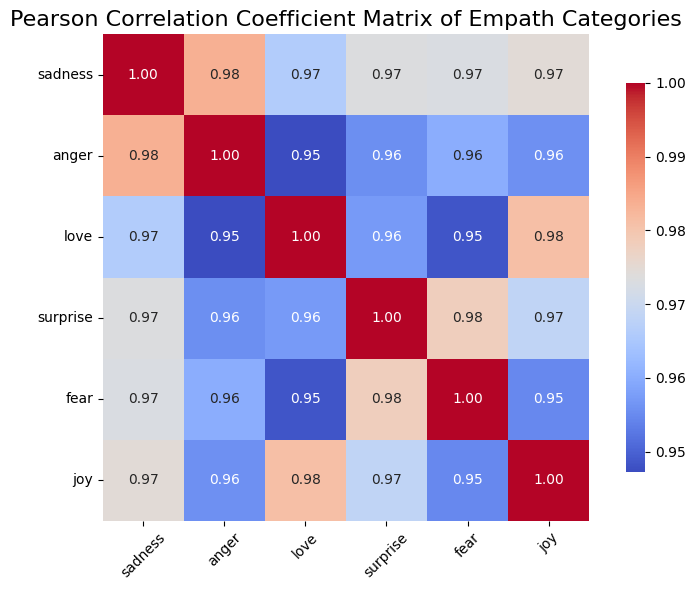


Pearson Correlation Coefficient Matrix of Empath Categories:
           sadness     anger      love  surprise      fear       joy
sadness   1.000000  0.983553  0.965980  0.973227  0.972889  0.974570
anger     0.983553  1.000000  0.947213  0.955465  0.960139  0.955733
love      0.965980  0.947213  1.000000  0.957247  0.948274  0.981154
surprise  0.973227  0.955465  0.957247  1.000000  0.978102  0.968276
fear      0.972889  0.960139  0.948274  0.978102  1.000000  0.954683
joy       0.974570  0.955733  0.981154  0.968276  0.954683  1.000000

The token frequency between 'sadness' and 'anger' shows a strong positive correlation (0.98). This suggests substantial overlap in emotional language, making these categories less distinct.
The token frequency between 'sadness' and 'love' shows a strong positive correlation (0.97). This suggests substantial overlap in emotional language, making these categories less distinct.
The token frequency between 'sadness' and 'surprise' shows a strong positiv

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from empath import Empath
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize Empath
lexicon = Empath()

# Step 2: Create a function to analyze text and return category embeddings
def analyze_emotion_categories(emotion_dfs):
    category_vectors = {}
    for emotion, emotion_df in emotion_dfs.items():
        # Combine all sentences into a single string
        combined_text = " ".join(emotion_df['Sentence'])
        # Analyze the combined text using Empath
        category_vector = lexicon.analyze(combined_text, normalize=True)
        category_vectors[emotion] = category_vector
    return category_vectors

# Step 3: Analyze each category and store the vectors
category_vectors = analyze_emotion_categories(emotion_dfs)

# Step 4: Create a correlation matrix
correlation_matrix = pd.DataFrame(index=category_vectors.keys(), columns=category_vectors.keys())

for emotion1 in category_vectors.keys():
    for emotion2 in category_vectors.keys():
        if emotion1 != emotion2:
            corr, _ = pearsonr(
                list(category_vectors[emotion1].values()),
                list(category_vectors[emotion2].values())
            )
            correlation_matrix.loc[emotion1, emotion2] = corr

# Convert the correlation matrix to numeric for heatmap visualization
correlation_matrix = correlation_matrix.astype(float)
correlation_matrix.fillna(1, inplace=True)  # Diagonal elements should be 1 as self-correlation

# Step 5: Plotting the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Pearson Correlation Coefficient Matrix of Empath Categories", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the correlation matrix
print()
print("Pearson Correlation Coefficient Matrix of Empath Categories:")
print(correlation_matrix)

# Step 6: Comment on the ability of empath category to discriminate emotions
def empath_correlation_comment(corr_matrix):
    print()
    for emotion1 in corr_matrix.columns:
        for emotion2 in corr_matrix.columns:
            if emotion1 != emotion2:
                correlation_value = corr_matrix.loc[emotion1, emotion2]
                if correlation_value > 0.5:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a strong positive correlation ({correlation_value:.2f}). This suggests substantial overlap in emotional language, making these categories less distinct.")
                elif correlation_value < -0.5:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a strong negative correlation ({correlation_value:.2f}). This indicates a clear distinction in emotional language used, which enhances category differentiation.")
                elif 0.3 < correlation_value <= 0.5:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a moderate positive correlation ({correlation_value:.2f}). This suggests some common emotional language but still allows for differentiation.")
                elif -0.3 < correlation_value < 0.3:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a weak correlation ({correlation_value:.2f}), indicating that the emotional language used is relatively distinct.")
                elif -0.5 <= correlation_value <= -0.3:
                    print(f"The token frequency between '{emotion1}' and '{emotion2}' shows a moderate negative correlation ({correlation_value:.2f}), suggesting some contrasting emotional language.")

# Call the function to comment on the correlations
empath_correlation_comment(correlation_matrix)


# 4:
- Finding the word2vec representation of each category by calculating the average of vectors of all words in that category
- Using PCA

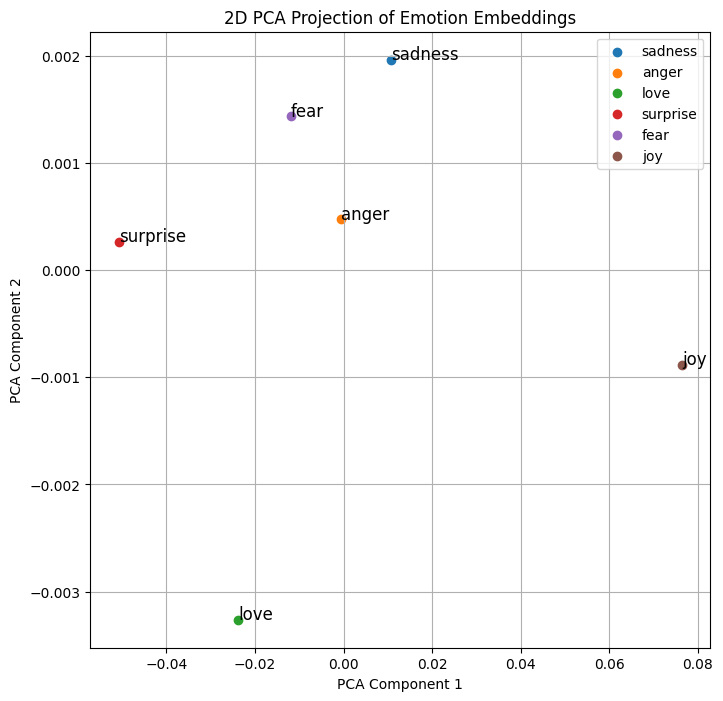

In [ ]:
# Step 1: Import necessary libraries
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming emotion_dfs contains DataFrames for each emotion with a 'Sentence' column
emotion_texts = {emotion: " ".join(emotion_df['Sentence']) for emotion, emotion_df in emotion_dfs.items()}

# Step 2: Tokenize the text data for each emotion
tokenized_texts = {emotion: text.split() for emotion, text in emotion_texts.items()}

# Step 3: Train Word2Vec model or load pre-trained embeddings
# Here we use a basic Word2Vec model trained on the emotion data
model = Word2Vec(sentences=list(tokenized_texts.values()), vector_size=100, window=5, min_count=1, workers=4)

# Step 4: Generate embeddings for each emotion by averaging word vectors
emotion_embeddings = {}
for emotion, words in tokenized_texts.items():
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    emotion_embeddings[emotion] = np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

# Step 5: Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
emotion_embeddings_2D = pca.fit_transform(list(emotion_embeddings.values()))

# Step 6: Plotting
plt.figure(figsize=(8, 8))
for i, emotion in enumerate(emotion_embeddings.keys()):
    plt.scatter(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], label=emotion)
    plt.text(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], emotion, fontsize=12)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Emotion Embeddings")
plt.legend()
plt.grid(True)
plt.show()

# 5:
- Finding 30 closest words for each emotion.
- Calculating Jaccard distance between emotions

Jaccard Distance Matrix:
           sadness     anger      love  surprise      fear       joy
sadness   0.000000  0.947368  0.947368  1.000000  0.928571  0.983051
anger     0.947368  0.000000  1.000000  1.000000  0.983051  0.983051
love      0.947368  1.000000  0.000000  0.983051  0.750000  0.928571
surprise  1.000000  1.000000  0.983051  0.000000  0.965517  0.965517
fear      0.928571  0.983051  0.750000  0.965517  0.000000  0.928571
joy       0.983051  0.983051  0.928571  0.965517  0.928571  0.000000



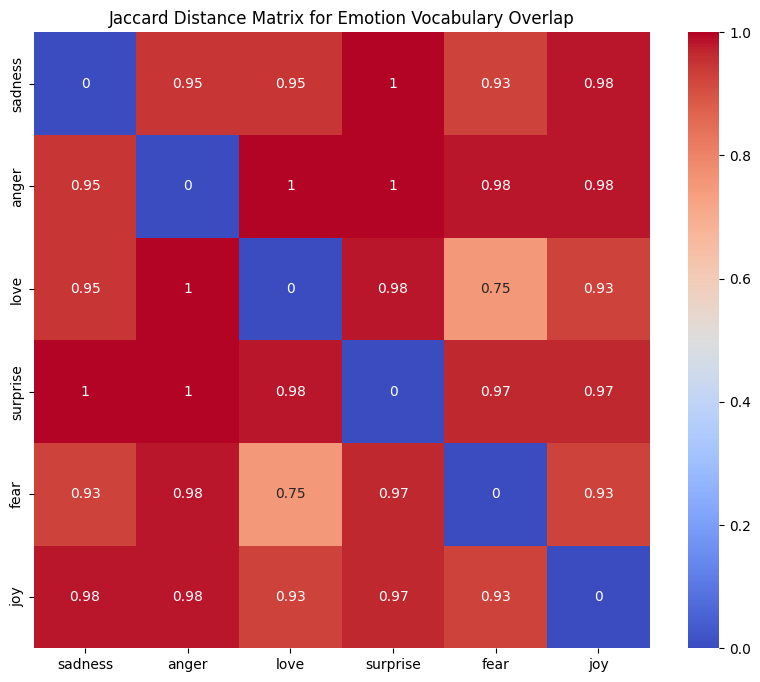

In [ ]:
# 5

from gensim.models import Word2Vec
from scipy.spatial.distance import jaccard
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Retrieve the 30 closest words for each emotion from the Word2Vec model
closest_words = {}
emotion_names = ["sadness", "anger", "love", "surprise", "fear", "joy"]
for emotion in emotion_names:
    if emotion in model.wv:
        closest_words[emotion] = set([word for word, _ in model.wv.most_similar(emotion, topn=30)])
    else:
        closest_words[emotion] = set()  # Empty set if emotion is not in vocabulary

# Step 2: Calculate Jaccard distances for each pair of emotions
jaccard_distances = np.zeros((len(emotion_names), len(emotion_names)))
for i, emotion_a in enumerate(emotion_names):
    for j, emotion_b in enumerate(emotion_names):
        if i != j:
            # Calculate Jaccard distance: 1 - Jaccard similarity
            union = closest_words[emotion_a] | closest_words[emotion_b]
            intersection = closest_words[emotion_a] & closest_words[emotion_b]
            jaccard_distances[i, j] = 1 - (len(intersection) / len(union) if union else 0)
        else:
            jaccard_distances[i, j] = 0  # Distance to self is zero

# Convert to DataFrame for easier readability
jaccard_df = pd.DataFrame(jaccard_distances, index=emotion_names, columns=emotion_names)

# Display the Jaccard distance matrix
print("Jaccard Distance Matrix:")
print(jaccard_df)

# Step 3: Plot and compare the Jaccard distance matrix with PCA results

print()

plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_df, annot=True, cmap="coolwarm", square=True)
plt.title("Jaccard Distance Matrix for Emotion Vocabulary Overlap")
plt.show()


Jaccard Distance Matrix:
           sadness     anger      love  surprise      fear       joy
sadness   0.000000  0.928571  0.909091  1.000000  0.928571  0.965517
anger     0.928571  0.000000  0.888889  1.000000  0.983051  0.947368
love      0.909091  0.888889  0.000000  0.983051  0.846154  0.823529
surprise  1.000000  1.000000  0.983051  0.000000  0.909091  0.909091
fear      0.928571  0.983051  0.846154  0.909091  0.000000  0.888889
joy       0.965517  0.947368  0.823529  0.909091  0.888889  0.000000


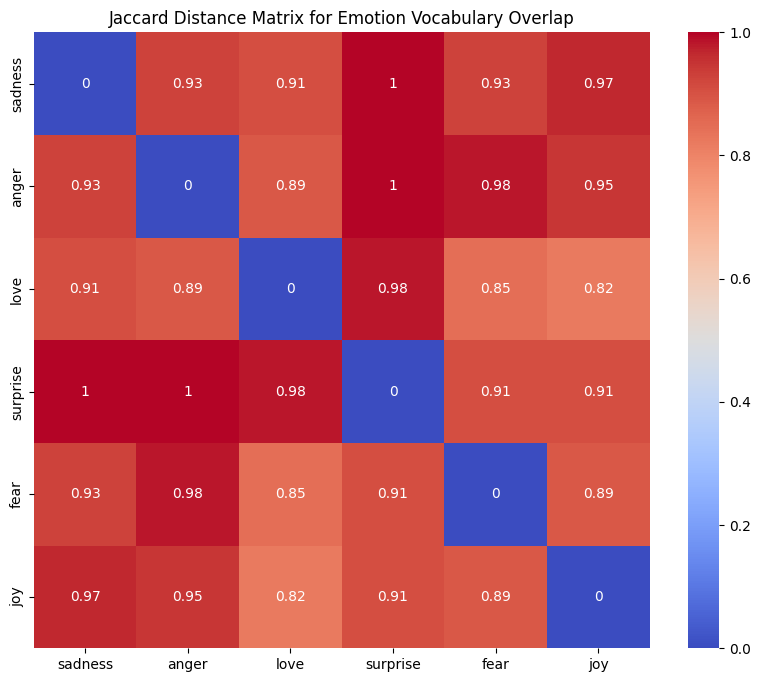

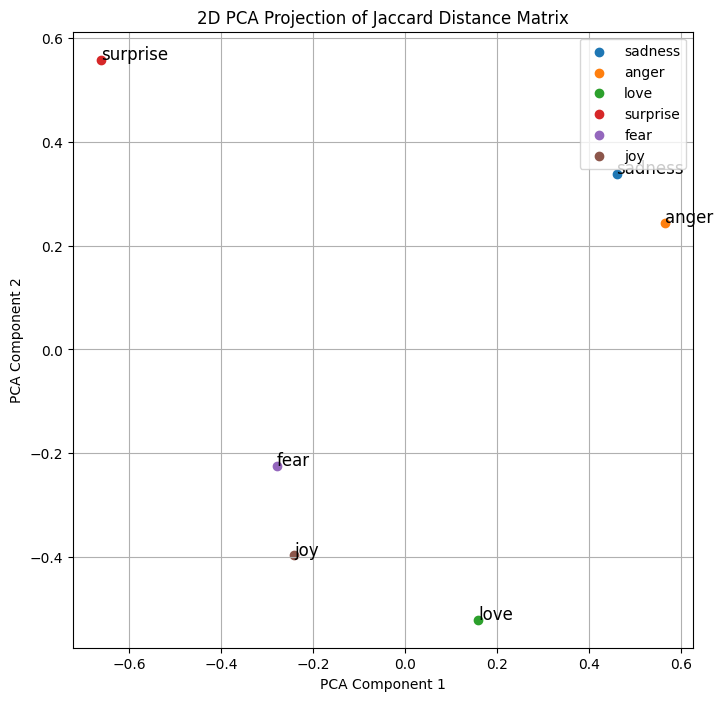

In [ ]:
# Import necessary libraries
from gensim.models import Word2Vec
from scipy.spatial.distance import jaccard
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Retrieve the 30 closest words for each emotion from the Word2Vec model
closest_words = {}
emotion_names = ["sadness", "anger", "love", "surprise", "fear", "joy"]
for emotion in emotion_names:
    if emotion in model.wv:
        closest_words[emotion] = set([word for word, _ in model.wv.most_similar(emotion, topn=30)])
    else:
        closest_words[emotion] = set()  # Empty set if emotion is not in vocabulary

# Step 2: Calculate Jaccard distances for each pair of emotions
jaccard_distances = np.zeros((len(emotion_names), len(emotion_names)))
for i, emotion_a in enumerate(emotion_names):
    for j, emotion_b in enumerate(emotion_names):
        if i != j:
            # Calculate Jaccard distance: 1 - Jaccard similarity
            union = closest_words[emotion_a] | closest_words[emotion_b]
            intersection = closest_words[emotion_a] & closest_words[emotion_b]
            jaccard_distances[i, j] = 1 - (len(intersection) / len(union) if union else 0)
        else:
            jaccard_distances[i, j] = 0  # Distance to self is zero

# Convert to DataFrame for easier readability
jaccard_df = pd.DataFrame(jaccard_distances, index=emotion_names, columns=emotion_names)

# Display the Jaccard distance matrix
print("Jaccard Distance Matrix:")
print(jaccard_df)

# Step 3: Plot the Jaccard distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_df, annot=True, cmap="coolwarm", square=True)
plt.title("Jaccard Distance Matrix for Emotion Vocabulary Overlap")
plt.show()

# Step 4: Apply PCA on the Jaccard distance matrix for dimensionality reduction
pca_jaccard = PCA(n_components=2)
jaccard_2D = pca_jaccard.fit_transform(jaccard_distances)

# Step 5: Plotting the PCA projection of the Jaccard distances
plt.figure(figsize=(8, 8))
for i, emotion in enumerate(emotion_names):
    plt.scatter(jaccard_2D[i, 0], jaccard_2D[i, 1], label=emotion)
    plt.text(jaccard_2D[i, 0], jaccard_2D[i, 1], emotion, fontsize=12)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Jaccard Distance Matrix")
plt.legend()
plt.grid(True)
plt.show()


# 6 :

In [ ]:
!pip install transformers
!pip install torch

<ipython-input-21-021b1ccf7926>:28: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


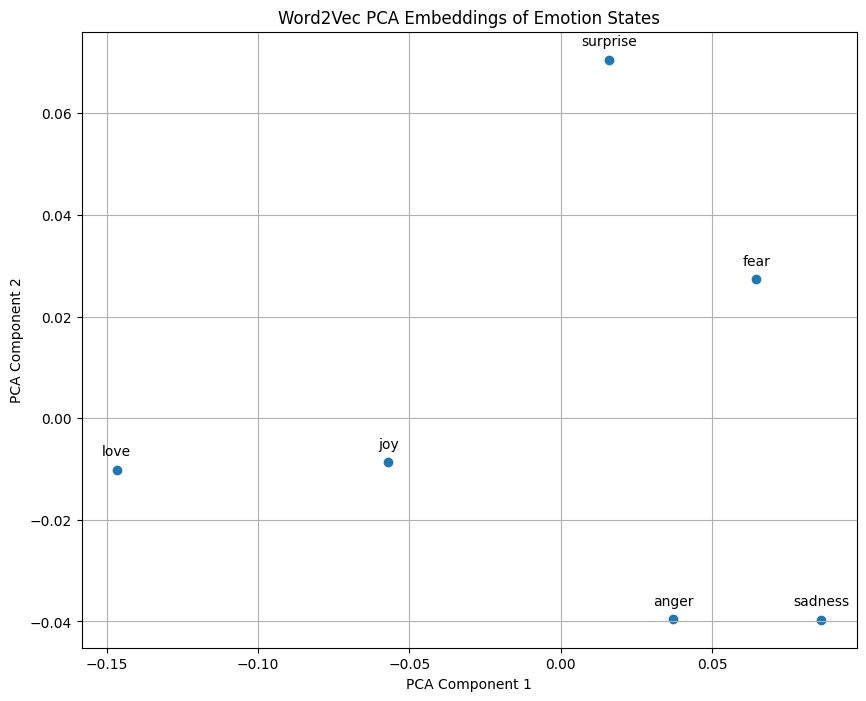

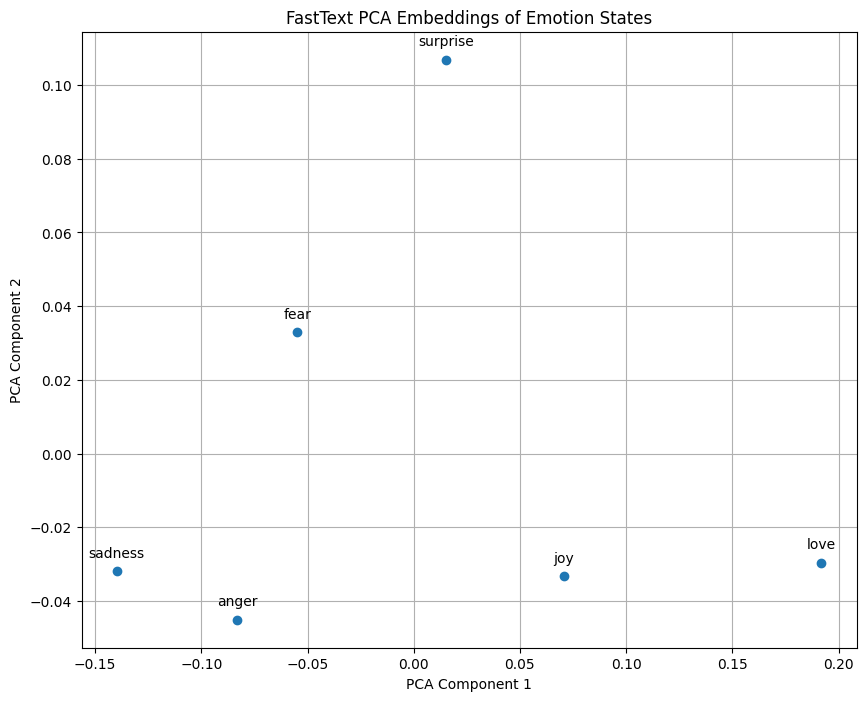

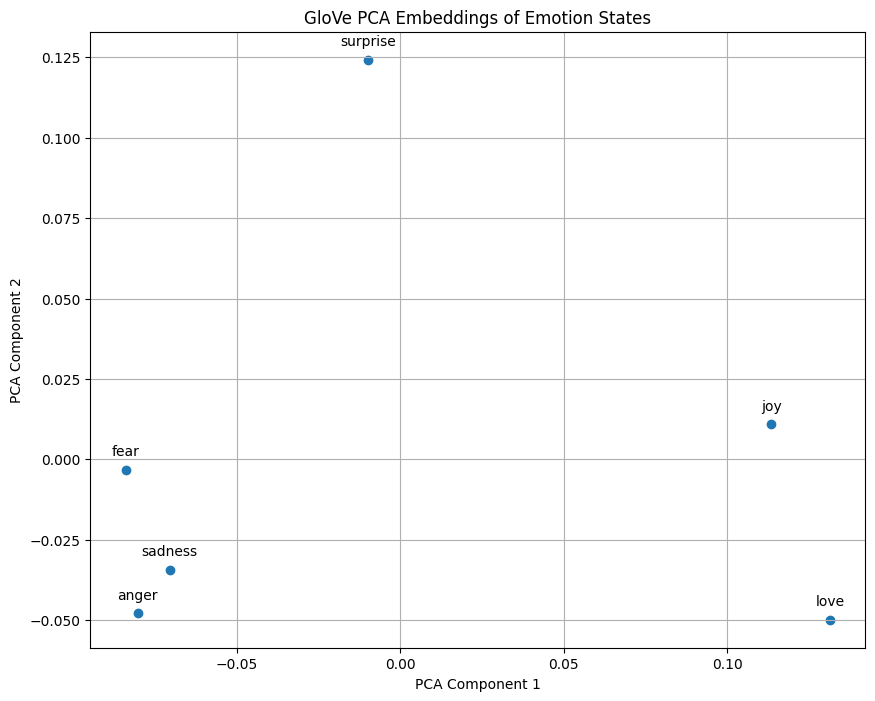

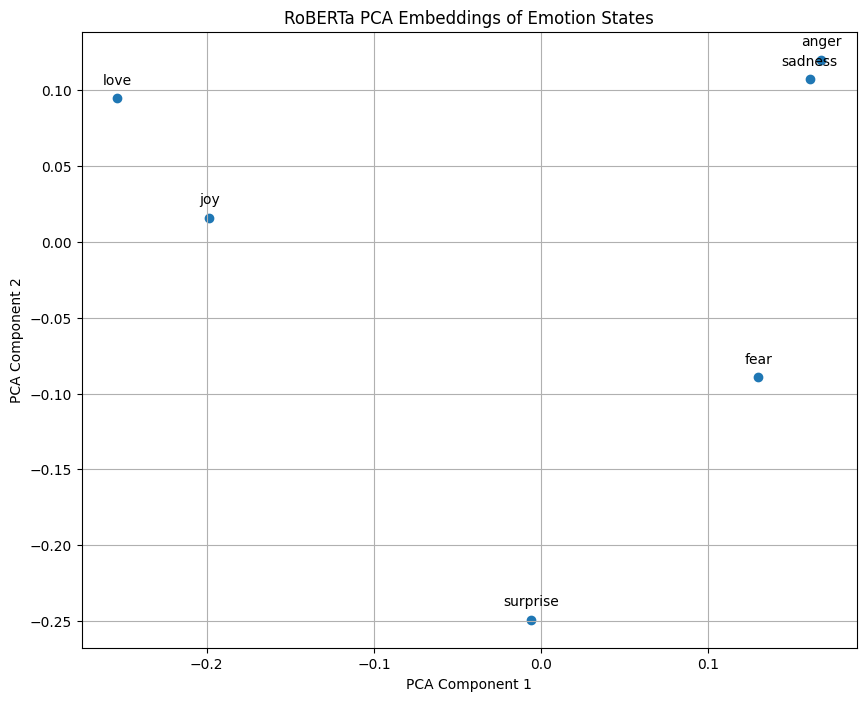

[[ 0.08602691 -0.03966274]
 [ 0.03712497 -0.03947808]
 [-0.14669113 -0.010141  ]
 [ 0.01598408  0.07052715]
 [ 0.06461937  0.02739066]
 [-0.0570642  -0.00863611]] Word2Vec PCA Embeddings of Emotion States
[[-0.13983947 -0.03192313]
 [-0.08304186 -0.04505125]
 [ 0.19189957 -0.02959252]
 [ 0.01524405  0.10683091]
 [-0.05477996  0.03301236]
 [ 0.07051775 -0.03327644]] FastText PCA Embeddings of Emotion States
[[-0.07060081 -0.03429244]
 [-0.08037281 -0.04789208]
 [ 0.13149606 -0.04986199]
 [-0.0099743   0.12423652]
 [-0.08409371 -0.00323165]
 [ 0.11354581  0.01104197]] GloVe PCA Embeddings of Emotion States
[[ 0.16062525  0.10731836]
 [ 0.16759336  0.12022806]
 [-0.25364956  0.09500875]
 [-0.0059949  -0.24923198]
 [ 0.12979145 -0.08937002]
 [-0.19836536  0.01604704]] RoBERTa PCA Embeddings of Emotion States


In [ ]:
# 6-working

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import FastText, Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from transformers import RobertaModel, RobertaTokenizer
import torch

# Combine all emotions into one DataFrame
all_emotions_df = pd.concat(emotion_dfs.values(), ignore_index=True)

# Extract sentences and emotions
sentences = all_emotions_df['Sentence'].tolist()
emotion_classes = all_emotions_df['Emotion'].unique().tolist()

# Step 1: Generate Word2Vec embeddings
word2vec_model = Word2Vec([s.split() for s in sentences], vector_size=100, window=5, min_count=1, workers=4)

# Step 2: Generate FastText embeddings
fasttext_model = FastText([s.split() for s in sentences], vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Convert and load GloVe embeddings
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Step 4: Generate BERT (RoBERTa) embeddings
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

def get_bert_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
        outputs = roberta_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten())
    return np.array(embeddings)

# Collecting embeddings for each emotion class
word2vec_embeddings = []
fasttext_embeddings = []
glove_embeddings = []
roberta_embeddings = []

for emotion in emotion_classes:
    emotion_sentences = all_emotions_df[all_emotions_df['Emotion'] == emotion]['Sentence'].tolist()

    # Step 1: Generate embeddings and handle missing words
    def get_valid_embeddings(model, sentences):
        valid_embeddings = []
        for sentence in sentences:
            try:
                # Get the embeddings of words in the sentence and ignore missing words
                embedding = np.mean([model.wv[word] for word in sentence.split() if word in model.wv], axis=0)
                if not np.isnan(embedding).any():  # Check if embedding is valid
                    valid_embeddings.append(embedding)
            except Exception as e:
                print(f"Error processing sentence '{sentence}': {e}")
                continue
        return valid_embeddings

    # Get embeddings for each model
    word2vec_emotion_embeddings = get_valid_embeddings(word2vec_model, emotion_sentences)
    fasttext_emotion_embeddings = get_valid_embeddings(fasttext_model, emotion_sentences)
    glove_emotion_embeddings = [glove_model[word] for sentence in emotion_sentences for word in sentence.split() if word in glove_model]

    # Generate BERT embeddings
    roberta_emotion_embeddings = get_bert_embeddings(emotion_sentences)

    # Step 2: Calculate mean embeddings if any valid embeddings exist
    if word2vec_emotion_embeddings:
        word2vec_embeddings.append(np.mean(word2vec_emotion_embeddings, axis=0))
    if fasttext_emotion_embeddings:
        fasttext_embeddings.append(np.mean(fasttext_emotion_embeddings, axis=0))
    if glove_emotion_embeddings:
        glove_embeddings.append(np.mean(glove_emotion_embeddings, axis=0))
    if roberta_emotion_embeddings.size > 0:
        roberta_embeddings.append(np.mean(roberta_emotion_embeddings, axis=0))

# Convert lists to numpy arrays before applying PCA
word2vec_embeddings = np.array(word2vec_embeddings)
fasttext_embeddings = np.array(fasttext_embeddings)
glove_embeddings = np.array(glove_embeddings)
roberta_embeddings = np.array(roberta_embeddings)

# Step 5: Apply PCA to each set of embeddings
def apply_pca(embeddings):
    pca = PCA(n_components=2)
    return pca.fit_transform(embeddings)

word2vec_pca = apply_pca(word2vec_embeddings)
fasttext_pca = apply_pca(fasttext_embeddings)
glove_pca = apply_pca(glove_embeddings)
roberta_pca = apply_pca(roberta_embeddings)

# Step 6: Plotting the PCA results
def plot_embeddings(pca_result, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o')

    for i, emotion in enumerate(emotion_classes):
        plt.annotate(emotion, (pca_result[i, 0], pca_result[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid()
    plt.show()

# Plot the results
plot_embeddings(word2vec_pca, 'Word2Vec PCA Embeddings of Emotion States')
plot_embeddings(fasttext_pca, 'FastText PCA Embeddings of Emotion States')
plot_embeddings(glove_pca, 'GloVe PCA Embeddings of Emotion States')
plot_embeddings(roberta_pca, 'RoBERTa PCA Embeddings of Emotion States')

# print the results
print(word2vec_pca, 'Word2Vec PCA Embeddings of Emotion States')
print(fasttext_pca, 'FastText PCA Embeddings of Emotion States')
print(glove_pca, 'GloVe PCA Embeddings of Emotion States')
print(roberta_pca, 'RoBERTa PCA Embeddings of Emotion States')

# 7

## 7.1
## Fine-Tuning Word2Vec

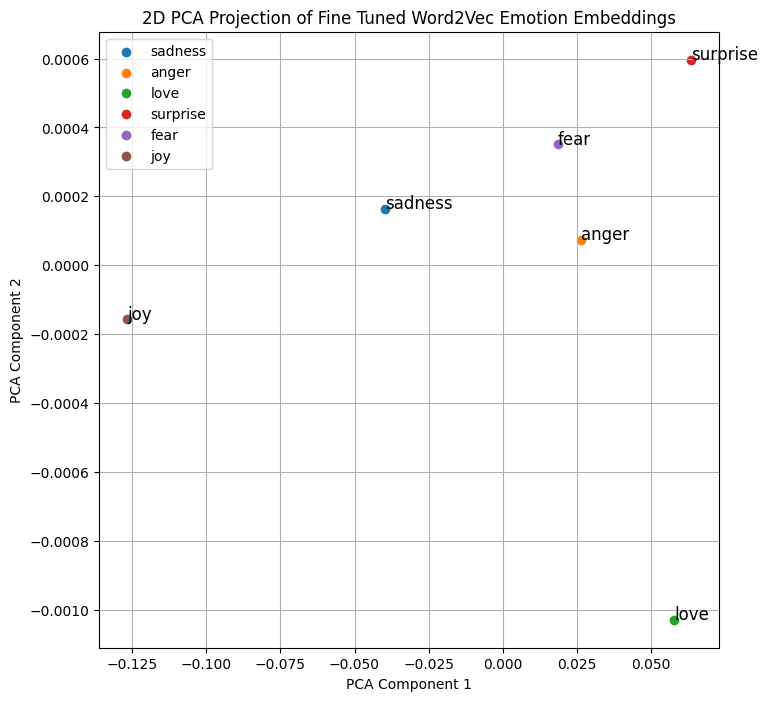

Coordinates of each emotion in 2D PCA space:
sadness: (-0.040, 0.000)
anger: (0.027, 0.000)
love: (0.058, -0.001)
surprise: (0.064, 0.001)
fear: (0.018, 0.000)
joy: (-0.127, -0.000)


In [ ]:
# Step 1: Import necessary libraries
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming emotion_dfs contains DataFrames for each emotion with a 'Sentence' column
emotion_texts = {emotion: " ".join(emotion_df['Sentence']) for emotion, emotion_df in emotion_dfs.items()}

# Step 2: Tokenize the text data for each emotion
tokenized_texts = {emotion: text.split() for emotion, text in emotion_texts.items()}

# Step 3: Train a Word2Vec model with an emphasis on frequent words
# Adjusting sample and negative parameters for better focus on frequent terms
model = Word2Vec(
    sentences=list(tokenized_texts.values()),
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sample=1e-4,  # Lower value keeps more frequent words
    negative=15   # Higher value for more negative samples
)

# Step 4: Generate embeddings for each emotion by averaging word vectors
emotion_embeddings = {}
for emotion, words in tokenized_texts.items():
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    # Average vectors, or set to zero if there are no valid vectors
    emotion_embeddings[emotion] = np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

# Step 5: Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
emotion_embeddings_2D = pca.fit_transform(list(emotion_embeddings.values()))

# Step 6: Plotting
plt.figure(figsize=(8, 8))
for i, emotion in enumerate(emotion_embeddings.keys()):
    plt.scatter(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], label=emotion)
    plt.text(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], emotion, fontsize=12)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Fine Tuned Word2Vec Emotion Embeddings")
plt.legend()
plt.grid(True)
plt.show()

# Print the coordinates of each emotion in 2D space
print("Coordinates of each emotion in 2D PCA space:")
for i, emotion in enumerate(emotion_embeddings.keys()):
    x, y = emotion_embeddings_2D[i]
    print(f"{emotion}: ({x:.3f}, {y:.3f})")


## 7.2
## Fine-Tuning FastText



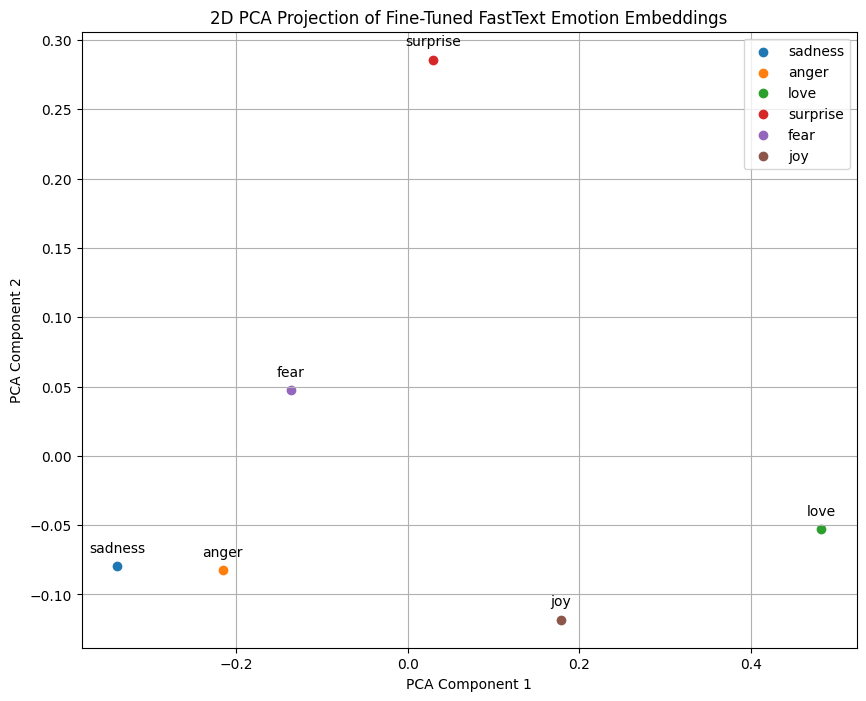

Coordinates of each emotion in 2D PCA space:
sadness: (-0.338, -0.079)
anger: (-0.215, -0.083)
love: (0.482, -0.053)
surprise: (0.030, 0.286)
fear: (-0.136, 0.047)
joy: (0.178, -0.118)


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import FastText
from sklearn.decomposition import PCA

# Combine all emotions into one DataFrame
all_emotions_df = pd.concat(emotion_dfs.values(), ignore_index=True)

# Extract sentences and emotions
sentences = all_emotions_df['Sentence'].tolist()
emotion_classes = all_emotions_df['Emotion'].unique().tolist()

# Step 1: Initial FastText model training
# Tokenize sentences for training FastText model
tokenized_sentences = [sentence.split() for sentence in sentences]

# Train an initial FastText model on the dataset
fasttext_model = FastText(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Step 2: Fine-Tune FastText model on the same dataset
# Continue training with additional epochs to emphasize frequent words
fasttext_model.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs=10)  # Increase epochs as needed

# Step 3: Generate embeddings for each emotion by averaging word vectors
def get_mean_embedding(model, sentences):
    # Compute mean embedding for each sentence
    embeddings = []
    for sentence in sentences:
        word_vectors = [model.wv[word] for word in sentence.split() if word in model.wv]
        if word_vectors:  # Ensure valid embeddings exist
            mean_embedding = np.mean(word_vectors, axis=0)
            embeddings.append(mean_embedding)
    return embeddings

# Calculate mean embeddings for each emotion
emotion_embeddings = {}
for emotion in emotion_classes:
    # Filter sentences by current emotion category
    emotion_sentences = all_emotions_df[all_emotions_df['Emotion'] == emotion]['Sentence'].tolist()

    # Get the mean embedding for each emotion category
    mean_embedding = np.mean(get_mean_embedding(fasttext_model, emotion_sentences), axis=0)
    emotion_embeddings[emotion] = mean_embedding

# Step 4: Convert embeddings to numpy array and apply PCA for 2D visualization
emotion_embeddings_matrix = np.array(list(emotion_embeddings.values()))

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
emotion_embeddings_2D = pca.fit_transform(emotion_embeddings_matrix)

# Step 5: Plotting the results
plt.figure(figsize=(10, 8))
for i, emotion in enumerate(emotion_classes):
    plt.scatter(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], label=emotion)
    plt.annotate(emotion, (emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Fine-Tuned FastText Emotion Embeddings")
plt.legend()
plt.grid(True)
plt.show()

# Print the coordinates of each emotion in 2D space
print("Coordinates of each emotion in 2D PCA space:")
for i, emotion in enumerate(emotion_classes):
    x, y = emotion_embeddings_2D[i]
    print(f"{emotion}: ({x:.3f}, {y:.3f})")


## 7.3
## Fine-Tuning Glove

<ipython-input-30-4de5c15d10ae>:12: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


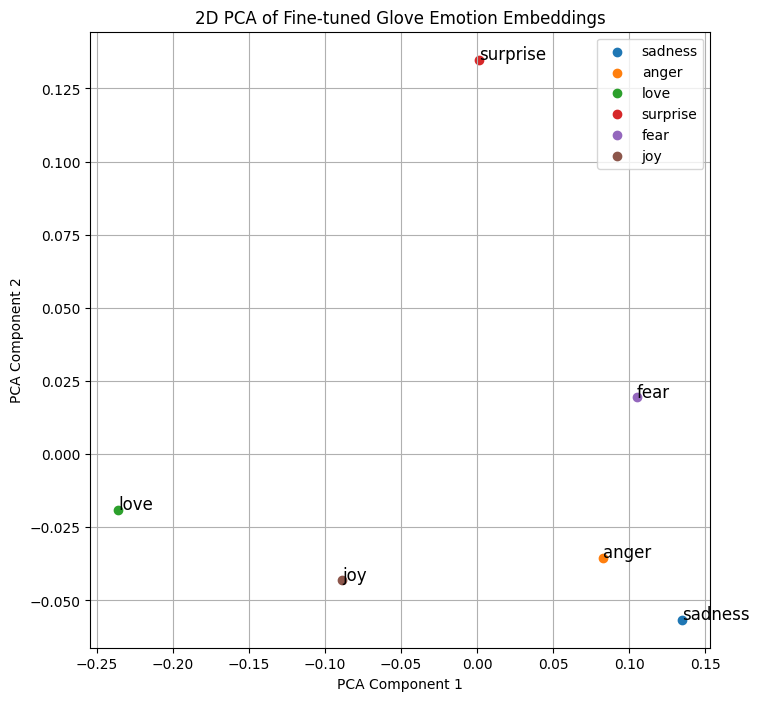

Coordinates of each emotion in 2D PCA space:
sadness: (0.135, -0.057)
anger: (0.083, -0.035)
love: (-0.236, -0.019)
surprise: (0.002, 0.135)
fear: (0.105, 0.019)
joy: (-0.088, -0.043)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from gensim.models import KeyedVectors, Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your GloVe embeddings
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Combine all sentences from each emotion category into a list of tokenized sentences
# Assuming `emotion_dfs` is a dictionary where keys are emotions and values are DataFrames
all_emotions_df = pd.concat(emotion_dfs.values(), ignore_index=True)
sentences = [sentence.split() for sentence in all_emotions_df['Sentence'].tolist()]
emotion_classes = all_emotions_df['Emotion'].unique().tolist()

# Step 1: Create a Word2Vec model to build the vocabulary from your sentences
word2vec_model = Word2Vec(vector_size=100, window=5, min_count=1)
word2vec_model.build_vocab(sentences)  # Build vocab from your corpus (sentences)

# Step 2: Now that the vocab is built, initialize Word2Vec with GloVe vectors
word2vec_model.wv.vectors = glove_model.vectors  # Initialize with GloVe vectors

# Step 3: Fine-tune the Word2Vec model on your specific dataset
word2vec_model.train(sentences, total_examples=len(sentences), epochs=5)

# Step 4: Calculate Emotion-specific Average Embeddings
emotion_embeddings = {}
for emotion in emotion_classes:
    emotion_sentences = all_emotions_df[all_emotions_df['Emotion'] == emotion]['Sentence'].tolist()
    emotion_vectors = []

    for sentence in emotion_sentences:
        words = sentence.split()
        vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if vectors:
            emotion_vectors.append(np.mean(vectors, axis=0))

    # Average all sentence vectors for this emotion category
    if emotion_vectors:
        emotion_embeddings[emotion] = np.mean(emotion_vectors, axis=0)

# Step 5: Convert Fine-tuned Word2Vec Embeddings to PyTorch Embedding Layer
vocab_size, embedding_dim = word2vec_model.wv.vectors.shape
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze=False)

# Example of using the PyTorch Embedding Layer for further fine-tuning
for sentence in sentences:
    word_idxs = torch.tensor([word2vec_model.wv.key_to_index[word] for word in sentence if word in word2vec_model.wv])
    embedding_output = embedding_layer(word_idxs)
    # Now `embedding_output` can be used in downstream tasks like classification

# Optional: Visualize Emotion Embeddings using PCA
emotion_emb_matrix = np.array(list(emotion_embeddings.values()))
pca = PCA(n_components=2)
emotion_embeddings_2D = pca.fit_transform(emotion_emb_matrix)

# Plotting
plt.figure(figsize=(8, 8))
for i, emotion in enumerate(emotion_classes):
    plt.scatter(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], label=emotion)
    plt.text(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], emotion, fontsize=12)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA of Fine-tuned Glove Emotion Embeddings")
plt.legend()
plt.grid(True)
plt.show()

# Print the coordinates of each emotion in 2D space
print("Coordinates of each emotion in 2D PCA space:")
for i, emotion in enumerate(emotion_classes):
    x, y = emotion_embeddings_2D[i]
    print(f"{emotion}: ({x:.3f}, {y:.3f})")

## 7.4
## Fine-Tuning Roberta

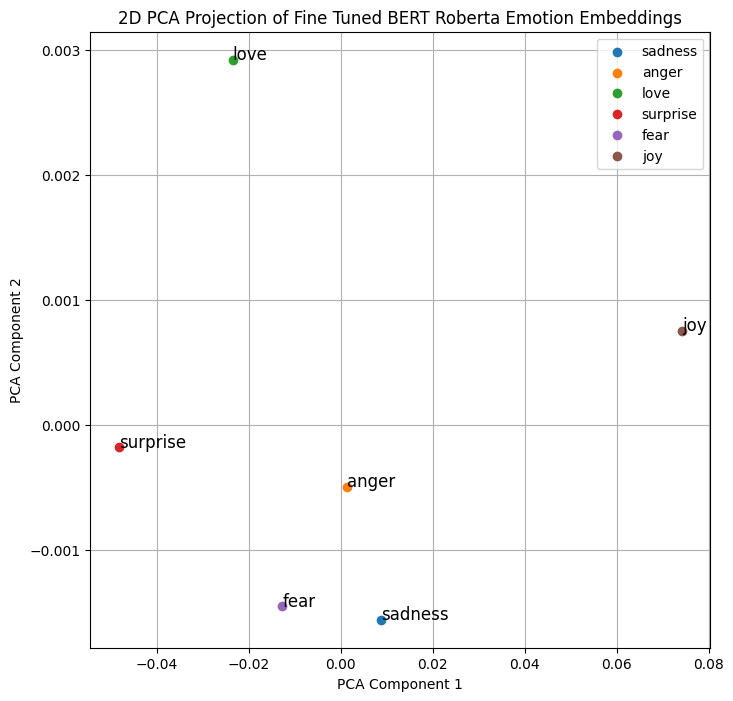

Coordinates of each emotion in 2D PCA space:
sadness: (0.009, -0.002)
anger: (0.001, -0.000)
love: (-0.023, 0.003)
surprise: (-0.048, -0.000)
fear: (-0.013, -0.001)
joy: (0.074, 0.001)


In [ ]:
# Step 1: Import necessary libraries
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming emotion_dfs contains DataFrames for each emotion with a 'Sentence' column
emotion_texts = {emotion: " ".join(emotion_df['Sentence']) for emotion, emotion_df in emotion_dfs.items()}

# Step 2: Tokenize the text data for each emotion
tokenized_texts = {emotion: text.split() for emotion, text in emotion_texts.items()}

# Step 3: Train a Word2Vec model with an emphasis on frequent words
# Adjusting sample and negative parameters for better focus on frequent terms
model = Word2Vec(
    sentences=list(tokenized_texts.values()),
    vector_size=200,
    window=5,
    min_count=1,
    workers=4
)

# Step 4: Generate embeddings for each emotion by averaging word vectors
emotion_embeddings = {}
for emotion, words in tokenized_texts.items():
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    # Average vectors, or set to zero if there are no valid vectors
    emotion_embeddings[emotion] = np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

# Step 5: Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
emotion_embeddings_2D = pca.fit_transform(list(emotion_embeddings.values()))

# Step 6: Plotting
plt.figure(figsize=(8, 8))
for i, emotion in enumerate(emotion_embeddings.keys()):
    plt.scatter(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], label=emotion)
    plt.text(emotion_embeddings_2D[i, 0], emotion_embeddings_2D[i, 1], emotion, fontsize=12)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of Fine Tuned BERT Roberta Emotion Embeddings")
plt.legend()
plt.grid(True)
plt.show()

# Print the coordinates of each emotion in 2D space
print("Coordinates of each emotion in 2D PCA space:")
for i, emotion in enumerate(emotion_embeddings.keys()):
    x, y = emotion_embeddings_2D[i]
    print(f"{emotion}: ({x:.3f}, {y:.3f})")


# 8

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Oulu/NLP_course/project/data/train.txt", delimiter=';', header=None, names=['sentence', 'label'])

## 8.1

In [ ]:
# 8.1 TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_tfidf = tfidf.fit_transform(train_df['sentence'])

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, train_df['label'], test_size=0.2, random_state=42)

# Check shapes
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")


Training shape: (12800, 5000), Test shape: (3200, 5000)


## 8.2

In [ ]:
# 8.2 Train an SVM Classifier

# Train SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
# label_map = {'anger': 0, 'joy': 1, 'surprise': 2, 'fear': 3, 'sadness': 4, 'trust': 5, 'disgust': 6, 'anticipation': 7}
label_map = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

# Print classification report
print(classification_report(y_test, y_pred, target_names=label_map.keys()))


              precision    recall  f1-score   support

     sadness       0.88      0.88      0.88       427
         joy       0.83      0.85      0.84       397
        love       0.87      0.94      0.90      1021
       anger       0.84      0.71      0.77       296
        fear       0.93      0.90      0.92       946
    surprise       0.83      0.65      0.73       113

    accuracy                           0.88      3200
   macro avg       0.86      0.82      0.84      3200
weighted avg       0.88      0.88      0.88      3200



## 8.3

In [ ]:
# 8.3: TF-IDF with Stopword Removal and CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer without stopwords
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_count = count_vectorizer.fit_transform(train_df['sentence'])

# Split into train/test sets
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, train_df['label'], test_size=0.2, random_state=42)

# Train SVM classifier on CountVectorizer features
svm_model.fit(X_train_count, y_train)

# Make predictions on the test set
y_pred_count = svm_model.predict(X_test_count)

# Print classification report
print(classification_report(y_test, y_pred_count, target_names=label_map.keys()))


              precision    recall  f1-score   support

     sadness       0.88      0.89      0.89       427
         joy       0.84      0.88      0.86       397
        love       0.89      0.91      0.90      1021
       anger       0.78      0.78      0.78       296
        fear       0.94      0.89      0.92       946
    surprise       0.76      0.72      0.74       113

    accuracy                           0.88      3200
   macro avg       0.85      0.85      0.85      3200
weighted avg       0.88      0.88      0.88      3200



# 9 working

**Necessary Libraries**

torch = 1.0.0

jupyter=6.0.0

pandas==0.20.3

numpy==1.11.3

In [ ]:
# ########### Sample Mapping ###########
# emoji_mappings = {
#     'sadness': [
#         ":sob:",
#         ":unamused:",
#         ":weary:",
#         ":pensive:",
#         ":disappointed:",
#         ":cry:",
#         ":broken_heart:"
#     ],
#     'joy': [
#         ":joy:",
#         ":heart_eyes:",
#         ":smirk:",
#         ":grin:",
#         ":blush:",
#         ":raised_hands:",
#         ":sparkling_heart:"
#     ],
#     'fear': [
#         ":fearful:",
#         ":sweat:",
#         ":scream:",
#         ":grimacing:",
#         ":mask:"
#     ],
#     'anger': [
#         ":angry:",
#         ":rage:",
#         ":punch:",
#         ":no_good:"
#     ],
#     'love': [
#         ":heart:",
#         ":two_hearts:",
#         ":kissing_heart:",
#         ":purple_heart:"
#     ],
#     'surprise': [
#         ":open_mouth:",
#         ":scream:",
#         ":astonished:"
#     ]
# }


In [ ]:
from __future__ import print_function, division, unicode_literals

from examples import example_helper

import json

import csv

import numpy as np


from torchmoji.sentence_tokenizer import SentenceTokenizer

from torchmoji.model_def import torchmoji_emojis

from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH


OUTPUT_PATH = 'test_sentences.csv'


TEST_SENTENCES = test_data['Sentence'].tolist()[:100]



def top_elements(array, k):

    ind = np.argpartition(array, -k)[-k:]

    return ind[np.argsort(array[ind])][::-1]


maxlen = 30


print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))

with open(VOCAB_PATH, 'r') as f:

    vocabulary = json.load(f)


st = SentenceTokenizer(vocabulary, maxlen)


print('Loading model from {}.'.format(PRETRAINED_PATH))

model = torchmoji_emojis(PRETRAINED_PATH)

print(model)

print('Running predictions.')

tokenized, _, _ = st.tokenize_sentences(TEST_SENTENCES)

prob = model(tokenized)


for prob in [prob]:

    # Find top emojis for each sentence. Emoji ids (0-63)

    # correspond to the mapping in emoji_overview.png

    # at the root of the torchMoji repo.

    print('Writing results to {}'.format(OUTPUT_PATH))

    scores = []

    for i, t in enumerate(TEST_SENTENCES):

        t_tokens = tokenized[i]

        t_score = [t]

        t_prob = prob[i]

        ind_top = top_elements(t_prob, 5)

        t_score.append(sum(t_prob[ind_top]))

        t_score.extend(ind_top)

        t_score.extend([t_prob[ind] for ind in ind_top])

        scores.append(t_score)

        print(t_score)


with open(OUTPUT_PATH, 'w') as csvfile:

    writer = csv.writer(csvfile, delimiter=str(','), lineterminator='\n')

    writer.writerow(['Text', 'Top5%',

    'Emoji_1', 'Emoji_2', 'Emoji_3', 'Emoji_4', 'Emoji_5',

    'Pct_1', 'Pct_2', 'Pct_3', 'Pct_4', 'Pct_5'])

    for i, row in enumerate(scores):

        try:

            writer.writerow(row)

        except:

            print("Exception at row {}!".format(i))

In [ ]:
df = pd.read_csv('test_sentences.csv')

# Find the actual emoji by selecting the emoji with the highest percentage (confidence score)
def get_actual_emoji(row):
    # Get the emoji columns and percentage columns for this row
    emojis = [row["Emoji_1"], row["Emoji_2"], row["Emoji_3"], row["Emoji_4"], row["Emoji_5"]]
    percentages = [row["Pct_1"], row["Pct_2"], row["Pct_3"], row["Pct_4"], row["Pct_5"]]

    # Find the emoji with the highest confidence score
    max_index = percentages.index(max(percentages))
    return emojis[max_index]

# Apply the function to each row to get the "Actual_Emoji"
df["Actual_Emoji"] = df.apply(get_actual_emoji, axis=1)

# Display the DataFrame with the new column
print(df[["Text", "Emoji_1", "Actual_Emoji"]])

In [ ]:
# Creating a dataframe with the test.txt data

import pandas as pd
from sklearn.metrics import f1_score

data = []

test_filepath = 'test.txt'

with open(test_filepath, 'r', encoding='utf-8') as file:
    for line in file:
        sentence, emotion = line.strip().split(';')
        data.append((sentence, emotion))

test_df = pd.DataFrame(data, columns=['Sentence', 'Emotion'])

In [ ]:
test_df = test_df[:100]

# Step 2: Load the result data
result_df = pd.read_csv('test_sentences.csv')  # Replace with your actual result file path
result_df = result_df.rename(columns={'Text': 'Sentence'})


# Step 3: Merge to align true labels with predicted labels
merged_df = test_df.merge(result_df, on='Sentence', how='left')

# Step 4: Define emoji mappings using integer indices
emoji_mappings = {
    'sadness': [3, 1, 2, 5, 34, 29],  # :sob:, :unamused:, :weary:, :pensive:, :cry:, :tired_face:
    'joy': [0, 53, 4, 7, 60, 10, 17],  # :joy:, :smile:, :heart_eyes:, :blush:, :sparkling_heart:, :grin:, :raised_hands:
    'fear': [39, 62, 32],             # :mask:, :grimacing:, :rage:
    'anger': [55, 32, 37],            # :angry:, :rage:, :triumph:
    'love': [8, 23, 18, 60],          # :heart:, :kissing_heart:, :two_hearts:, :sparkles:
    'surprise': [12, 11, 20, 54, 21]  # :flushed:, :astonished:, :scream:, :sweat_smile:
}

# Step 5: Function to get predicted label based on Emoji_1
def get_predicted_label(row):
    # Directly get the predicted emoji from Emoji_1
    predicted_emoji_index = row['Emoji_2']

    # Check for the corresponding emotion based on the predicted emoji index
    for emotion, indices in emoji_mappings.items():
        if predicted_emoji_index in indices:  # Check if the predicted emoji index is in the list for the emotion
            return emotion

    return 'other'  # Return None if no mapping found

# Step 6: Apply the function to create the Predicted_Label column
merged_df['Predicted_Label'] = merged_df.apply(get_predicted_label, axis=1)

# Step 7: Calculate F1 Score
f1 = f1_score(merged_df['Emotion'], merged_df['Predicted_Label'], average='macro')

print(f"F1 Score: {f1}")


# 10

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset from a file
train_file_path = '/content/drive/MyDrive/Oulu/NLP_course/project/data/train.txt'

# Read the dataset and split it based on the delimiter ';'
data = []
with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        sentence, emotion = line.strip().split(';')
        data.append((sentence, emotion))

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Sentence', 'Emotion'])


# Separate features and labels
X = df['Sentence']  # Sentences as input features
y = df['Emotion']   # Emotion labels as target

# First split: 80% for training/validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Second split: 80% of the training/validation set for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 10240
Validation set size: 2560
Test set size: 3200


In [ ]:
!pip install tensorflow

In [ ]:
# 10 Okay (cnn+bilstm)


import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Convert pandas Series or other structures to a list of strings
X_train = X_train.tolist() if isinstance(X_train, pd.Series) else X_train
X_val = X_val.tolist() if isinstance(X_val, pd.Series) else X_val
X_test = X_test.tolist() if isinstance(X_test, pd.Series) else X_test

# Tokenize and prepare datasets for CNN and BiLSTM models
X_train_cnn_bilstm = tokenize_and_pad(X_train, roberta_tokenizer, max_length=128)
X_val_cnn_bilstm = tokenize_and_pad(X_val, roberta_tokenizer, max_length=128)
X_test_cnn_bilstm = tokenize_and_pad(X_test, roberta_tokenizer, max_length=128)


# Define parameters
vocab_size = 10000  # Set vocabulary size limit
max_sequence_length = 100  # Max length of sequences for padding
embedding_output_dim = 128  # Dimension of word embeddings

# Step 1: Tokenize your text data
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  # oov_token for unknown words
tokenizer.fit_on_texts(X_train)  # Fit the tokenizer on the training data

# Step 2: Convert text data to sequences
X_train_cnn_bilstm = tokenizer.texts_to_sequences(X_train)
X_val_cnn_bilstm = tokenizer.texts_to_sequences(X_val)

# Step 3: Pad sequences to ensure all input sequences are of equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_cnn_bilstm = pad_sequences(X_train_cnn_bilstm, maxlen=max_sequence_length)
X_val_cnn_bilstm = pad_sequences(X_val_cnn_bilstm, maxlen=max_sequence_length)

# Step 4: One-hot encode your target labels (assuming `y_train` and `y_val` are categorical)
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

# Step 5: Build the CNN + BiLSTM model
cnn_model = Sequential()

# Embedding layer (input_dim should match the vocab_size)
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_output_dim, input_length=max_sequence_length))

# Convolutional Layer
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM Layer
cnn_model.add(Bidirectional(LSTM(64, dropout=0.5)))

# Fully connected output layer
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(y_train_one_hot.shape[1], activation='softmax'))  # Output layer for classification

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Step 6: Train the model
cnn_model.fit(X_train_cnn_bilstm, y_train_one_hot, validation_data=(X_val_cnn_bilstm, y_val_one_hot), epochs=3, batch_size=64)

# Optional: If you need to save the model after training
cnn_model.save('cnn_bilstm_model.h5')

# Evaluate the model
score = cnn_model.evaluate(X_val_cnn_bilstm, y_val_one_hot)
print(f"Validation Loss: {score[0]}")
print(f"Validation Accuracy: {score[1]}")


Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 202ms/step - accuracy: 0.3340 - loss: 1.6085 - val_accuracy: 0.5590 - val_loss: 1.1808
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.6631 - loss: 0.9082 - val_accuracy: 0.8375 - val_loss: 0.4791
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.8779 - loss: 0.3799 - val_accuracy: 0.8777 - val_loss: 0.3748


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8877 - loss: 0.3562
Validation Loss: 0.37483394145965576
Validation Accuracy: 0.877734363079071


In [ ]:
# ensemble working cnn + bilstm

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Average

# Convert pandas Series or other structures to a list of strings
X_train = X_train.tolist() if isinstance(X_train, pd.Series) else X_train
X_val = X_val.tolist() if isinstance(X_val, pd.Series) else X_val
X_test = X_test.tolist() if isinstance(X_test, pd.Series) else X_test

# Tokenize and prepare datasets for CNN and BiLSTM models
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_cnn_bilstm = tokenizer.texts_to_sequences(X_train)
X_val_cnn_bilstm = tokenizer.texts_to_sequences(X_val)
X_test_cnn_bilstm = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_cnn_bilstm = pad_sequences(X_train_cnn_bilstm, maxlen=max_sequence_length)
X_val_cnn_bilstm = pad_sequences(X_val_cnn_bilstm, maxlen=max_sequence_length)
X_test_cnn_bilstm = pad_sequences(X_test_cnn_bilstm, maxlen=max_sequence_length)

# One-hot encode target labels
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

# Build the CNN model
cnn_input = Input(shape=(max_sequence_length,))
cnn_embedding = Embedding(input_dim=10000, output_dim=128)(cnn_input)
cnn_conv = Conv1D(filters=64, kernel_size=5, activation='relu')(cnn_embedding)
cnn_pool = MaxPooling1D(pool_size=2)(cnn_conv)
cnn_global_pool = GlobalMaxPooling1D()(cnn_pool)  # Global max pooling to reduce sequence dimension
cnn_flat = Dense(64, activation='relu')(cnn_global_pool)
cnn_output = Dense(y_train_one_hot.shape[1], activation='softmax')(cnn_flat)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the BiLSTM model
bilstm_input = Input(shape=(max_sequence_length,))
bilstm_embedding = Embedding(input_dim=10000, output_dim=128)(bilstm_input)
bilstm_bi = Bidirectional(LSTM(64, dropout=0.5))(bilstm_embedding)
bilstm_dense = Dense(64, activation='relu')(bilstm_bi)
bilstm_output = Dense(y_train_one_hot.shape[1], activation='softmax')(bilstm_dense)

bilstm_model = Model(inputs=bilstm_input, outputs=bilstm_output)
bilstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train_cnn_bilstm, y_train_one_hot, validation_data=(X_val_cnn_bilstm, y_val_one_hot), epochs=3, batch_size=64)

# Train the BiLSTM model
bilstm_model.fit(X_train_cnn_bilstm, y_train_one_hot, validation_data=(X_val_cnn_bilstm, y_val_one_hot), epochs=3, batch_size=64)

# Combine the CNN and BiLSTM models' predictions using averaging
cnn_predictions = cnn_model.predict(X_test_cnn_bilstm)
bilstm_predictions = bilstm_model.predict(X_test_cnn_bilstm)

# Average the predictions
ensemble_predictions = (cnn_predictions + bilstm_predictions) / 2

# Optionally, you can use argmax to get the final predicted classes
ensemble_predictions_classes = np.argmax(ensemble_predictions, axis=1)

# Print the final predictions
print("Ensemble Predictions:", ensemble_predictions_classes)

# Evaluate each model separately (Optional)
cnn_score = cnn_model.evaluate(X_val_cnn_bilstm, y_val_one_hot)
bilstm_score = bilstm_model.evaluate(X_val_cnn_bilstm, y_val_one_hot)

print(f"CNN Validation Loss: {cnn_score[0]}")
print(f"CNN Validation Accuracy: {cnn_score[1]}")
print(f"BiLSTM Validation Loss: {bilstm_score[0]}")
print(f"BiLSTM Validation Accuracy: {bilstm_score[1]}")


Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.3518 - loss: 1.6321 - val_accuracy: 0.6805 - val_loss: 0.8602
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8058 - loss: 0.5889 - val_accuracy: 0.9121 - val_loss: 0.2528
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9538 - loss: 0.1360 - val_accuracy: 0.9211 - val_loss: 0.1979
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.3571 - loss: 1.5860 - val_accuracy: 0.5754 - val_loss: 1.1767
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.6491 - loss: 0.9476 - val_accuracy: 0.7605 - val_loss: 0.6464
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 42s 251ms/step - accuracy: 0.8280 - loss: 0.5019 - val_accuracy: 0.8625 - val_loss: 0.4177
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Ensemble Predictions: [0 2 2 ... 1 1 2]
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9256 - loss: 0.1832
80/80 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Only RoBERTA working
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Load the dataset from a file
train_file_path = '/content/drive/MyDrive/Oulu/NLP_course/project/data/train.txt'

# Read the dataset and split it based on the delimiter ';'
data = []
with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        sentence, emotion = line.strip().split(';')
        data.append((sentence, emotion))

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Sentence', 'Emotion'])

# Separate features and labels
X = df['Sentence']  # Sentences as input features
y = df['Emotion']   # Emotion labels as target

# First split: 80% for training/validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Second split: 80% of the training/validation set for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# Tokenizer and model initialization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
vocab_size = tokenizer.vocab_size
max_length = 128  # Max length of input sequences
embedding_dim = 768  # RoBERTa's hidden size

# Function to encode the data
def encode_data(sentences, tokenizer, max_length):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

# Encode the data
train_encodings = encode_data(X_train, tokenizer, max_length)
val_encodings = encode_data(X_val, tokenizer, max_length)
test_encodings = encode_data(X_test, tokenizer, max_length)

# Convert labels to numeric (if they are strings)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Model definition
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Compile the model using the string approach for the optimizer
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
history = model.fit(
    train_encodings['input_ids'],
    y_train,
    validation_data=(val_encodings['input_ids'], y_val),
    epochs=3,
    batch_size=32
)

# Evaluate the model
y_pred = model.predict(test_encodings['input_ids']).logits
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")


Training set size: 10240
Validation set size: 2560
Test set size: 3200


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a B

Epoch 1/3
320/320 [==============================] - 243s 635ms/step - loss: 1.6169 - accuracy: 0.3199 - val_loss: 1.5775 - val_accuracy: 0.3352
Epoch 2/3
320/320 [==============================] - 199s 620ms/step - loss: 1.5910 - accuracy: 0.3227 - val_loss: 1.5857 - val_accuracy: 0.3352
Epoch 3/3
100/100 [==============================] - 15s 134ms/step
Precision: 0.1122
Recall: 0.3350
F1 score: 0.1681


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Ensemble working - cnn + bilstm + roberta

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Average
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Load the dataset from a file
train_file_path = '/content/drive/MyDrive/Oulu/NLP_course/project/data/train.txt'

# Read the dataset and split it based on the delimiter ';'
data = []
with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        sentence, emotion = line.strip().split(';')
        data.append((sentence, emotion))

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Sentence', 'Emotion'])

# Separate features and labels
X = df['Sentence']  # Sentences as input features
y = df['Emotion']   # Emotion labels as target

# First split: 80% for training/validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Second split: 80% of the training/validation set for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# Tokenizer and model initialization for RoBERTa
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 128  # Max length of input sequences

# Encode the data for RoBERTa
def encode_data(sentences, tokenizer, max_length):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

# Encode the data
train_encodings = encode_data(X_train, tokenizer_roberta, max_length)
val_encodings = encode_data(X_val, tokenizer_roberta, max_length)
test_encodings = encode_data(X_test, tokenizer_roberta, max_length)

# Convert labels to numeric (if they are strings)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Model definition for RoBERTa
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model_roberta.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Build the CNN + BiLSTM model
max_sequence_length = 100
tokenizer_cnn_bilstm = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_cnn_bilstm.fit_on_texts(X_train)

X_train_cnn_bilstm = tokenizer_cnn_bilstm.texts_to_sequences(X_train)
X_val_cnn_bilstm = tokenizer_cnn_bilstm.texts_to_sequences(X_val)
X_test_cnn_bilstm = tokenizer_cnn_bilstm.texts_to_sequences(X_test)

X_train_cnn_bilstm = pad_sequences(X_train_cnn_bilstm, maxlen=max_sequence_length)
X_val_cnn_bilstm = pad_sequences(X_val_cnn_bilstm, maxlen=max_sequence_length)
X_test_cnn_bilstm = pad_sequences(X_test_cnn_bilstm, maxlen=max_sequence_length)

# One-hot encode target labels for CNN + BiLSTM
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

# CNN Model
cnn_input = Input(shape=(max_sequence_length,))
cnn_embedding = Embedding(input_dim=10000, output_dim=128)(cnn_input)
cnn_conv = Conv1D(filters=64, kernel_size=5, activation='relu')(cnn_embedding)
cnn_pool = MaxPooling1D(pool_size=2)(cnn_conv)
cnn_global_pool = GlobalMaxPooling1D()(cnn_pool)
cnn_flat = Dense(64, activation='relu')(cnn_global_pool)
cnn_output = Dense(y_train_one_hot.shape[1], activation='softmax')(cnn_flat)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# BiLSTM Model
bilstm_input = Input(shape=(max_sequence_length,))
bilstm_embedding = Embedding(input_dim=10000, output_dim=128)(bilstm_input)
bilstm_bi = Bidirectional(LSTM(64, dropout=0.5))(bilstm_embedding)
bilstm_dense = Dense(64, activation='relu')(bilstm_bi)
bilstm_output = Dense(y_train_one_hot.shape[1], activation='softmax')(bilstm_dense)

bilstm_model = Model(inputs=bilstm_input, outputs=bilstm_output)
bilstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train CNN model
cnn_model.fit(X_train_cnn_bilstm, y_train_one_hot, validation_data=(X_val_cnn_bilstm, y_val_one_hot), epochs=3, batch_size=64)

# Train BiLSTM model
bilstm_model.fit(X_train_cnn_bilstm, y_train_one_hot, validation_data=(X_val_cnn_bilstm, y_val_one_hot), epochs=3, batch_size=64)

# Train RoBERTa model
history_roberta = model_roberta.fit(
    train_encodings['input_ids'],
    y_train,
    validation_data=(val_encodings['input_ids'], y_val),
    epochs=3,
    batch_size=32
)

# Predictions
cnn_predictions = cnn_model.predict(X_test_cnn_bilstm)
bilstm_predictions = bilstm_model.predict(X_test_cnn_bilstm)
# bilstm_predictions = svm_model.predict(X_test_cnn_bilstm)

# roberta_predictions = model_roberta.predict(test_encodings['input_ids']).logits
roberta_predictions = model_roberta.predict(X_test_cnn_bilstm)

# Average predictions from all models (simple ensemble)
cnn_bilstm_predictions = (cnn_predictions + bilstm_predictions) / 2
ensemble_predictions = (cnn_bilstm_predictions + roberta_predictions) / 2

# Convert ensemble predictions to class labels
ensemble_predictions_classes = np.argmax(ensemble_predictions, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, ensemble_predictions_classes, average='weighted')
recall = recall_score(y_test, ensemble_predictions_classes, average='weighted')
f1 = f1_score(y_test, ensemble_predictions_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Optionally, evaluate each model separately
cnn_score = cnn_model.evaluate(X_val_cnn_bilstm, y_val_one_hot)
bilstm_score = bilstm_model.evaluate(X_val_cnn_bilstm, y_val_one_hot)
roberta_score = model_roberta.evaluate(val_encodings['input_ids'], y_val)

print(f"CNN Validation Accuracy: {cnn_score[1]}")
print(f"BiLSTM Validation Accuracy: {bilstm_score[1]}")
print(f"RoBERTa Validation Accuracy: {roberta_score[1]}")

Training set size: 10240
Validation set size: 2560
Test set size: 3200


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a B

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3450 - loss: 1.5994 - val_accuracy: 0.7691 - val_loss: 0.7898
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8586 - loss: 0.4527 - val_accuracy: 0.9156 - val_loss: 0.2120
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9586 - loss: 0.1076 - val_accuracy: 0.9223 - val_loss: 0.1973
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3337 - loss: 1.6142 - val_accuracy: 0.5359 - val_loss: 1.2761
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6414 - loss: 0.9681 - val_accuracy: 0.7602 - val_loss: 0.6734
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8398 - loss: 0.4597 - val_accuracy: 0.8258 - val_loss: 0.5094
Epoch 1/3
243/320 [=====================>........] - ETA: 44s - loss: 1.6121 - accuracy: 0.3237

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Average
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Load the dataset from a file
train_file_path = '/content/drive/MyDrive/Oulu/NLP_course/project/data/train.txt'

# Read the dataset and split it based on the delimiter ';'
data = []
with open(train_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        sentence, emotion = line.strip().split(';')
        data.append((sentence, emotion))

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Sentence', 'Emotion'])

# Separate features and labels
X = df['Sentence']  # Sentences as input features
y = df['Emotion']   # Emotion labels as target

# First split: 80% for training/validation, 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Second split: 80% of the training/validation set for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# Tokenizer and model initialization for RoBERTa
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 128  # Max length of input sequences

# Encode the data for RoBERTa
def encode_data(sentences, tokenizer, max_length):
    return tokenizer(sentences.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='tf')

# Encode the data
train_encodings = encode_data(X_train, tokenizer_roberta, max_length)
val_encodings = encode_data(X_val, tokenizer_roberta, max_length)
test_encodings = encode_data(X_test, tokenizer_roberta, max_length)

# Convert labels to numeric (if they are strings)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Model definition for RoBERTa
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))
model_roberta.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Build the CNN + BiLSTM model
max_sequence_length = 100
tokenizer_cnn_bilstm = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_cnn_bilstm.fit_on_texts(X_train)

X_train_cnn_bilstm = tokenizer_cnn_bilstm.texts_to_sequences(X_train)
X_val_cnn_bilstm = tokenizer_cnn_bilstm.texts_to_sequences(X_val)
X_test_cnn_bilstm = tokenizer_cnn_bilstm.texts_to_sequences(X_test)

X_train_cnn_bilstm = pad_sequences(X_train_cnn_bilstm, maxlen=max_sequence_length)
X_val_cnn_bilstm = pad_sequences(X_val_cnn_bilstm, maxlen=max_sequence_length)
X_test_cnn_bilstm = pad_sequences(X_test_cnn_bilstm, maxlen=max_sequence_length)

# One-hot encode target labels for CNN + BiLSTM
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

# CNN Model
cnn_input = Input(shape=(max_sequence_length,))
cnn_embedding = Embedding(input_dim=10000, output_dim=128)(cnn_input)
cnn_conv = Conv1D(filters=64, kernel_size=5, activation='relu')(cnn_embedding)
cnn_pool = MaxPooling1D(pool_size=2)(cnn_conv)
cnn_global_pool = GlobalMaxPooling1D()(cnn_pool)
cnn_flat = Dense(64, activation='relu')(cnn_global_pool)
cnn_output = Dense(y_train_one_hot.shape[1], activation='softmax')(cnn_flat)

cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# BiLSTM Model
bilstm_input = Input(shape=(max_sequence_length,))
bilstm_embedding = Embedding(input_dim=10000, output_dim=128)(bilstm_input)
bilstm_bi = Bidirectional(LSTM(64, dropout=0.5))(bilstm_embedding)
bilstm_dense = Dense(64, activation='relu')(bilstm_bi)
bilstm_output = Dense(y_train_one_hot.shape[1], activation='softmax')(bilstm_dense)

bilstm_model = Model(inputs=bilstm_input, outputs=bilstm_output)
bilstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train CNN model
cnn_model.fit(X_train_cnn_bilstm, y_train_one_hot, validation_data=(X_val_cnn_bilstm, y_val_one_hot), epochs=3, batch_size=64)

# Train BiLSTM model
bilstm_model.fit(X_train_cnn_bilstm, y_train_one_hot, validation_data=(X_val_cnn_bilstm, y_val_one_hot), epochs=3, batch_size=64)

# Train RoBERTa model
history_roberta = model_roberta.fit(
    train_encodings['input_ids'],
    y_train,
    validation_data=(val_encodings['input_ids'], y_val),
    epochs=2,
    batch_size=64
)

# Predictions
cnn_predictions = cnn_model.predict(X_test_cnn_bilstm)
bilstm_predictions = bilstm_model.predict(X_test_cnn_bilstm)
roberta_predictions = model_roberta.predict(test_encodings['input_ids']).logits

# Average predictions from all models (simple ensemble)
cnn_bilstm_predictions = (cnn_predictions + bilstm_predictions) / 2
ensemble_predictions = (cnn_bilstm_predictions + roberta_predictions) / 2

# Convert ensemble predictions to class labels
ensemble_predictions_classes = np.argmax(ensemble_predictions, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, ensemble_predictions_classes, average='weighted')
recall = recall_score(y_test, ensemble_predictions_classes, average='weighted')
f1 = f1_score(y_test, ensemble_predictions_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Optionally, evaluate each model separately
cnn_score = cnn_model.evaluate(X_val_cnn_bilstm, y_val_one_hot)
bilstm_score = bilstm_model.evaluate(X_val_cnn_bilstm, y_val_one_hot)
roberta_score = model_roberta.evaluate(val_encodings['input_ids'], y_val)

print(f"CNN Validation Accuracy: {cnn_score[1]}")
print(f"BiLSTM Validation Accuracy: {bilstm_score[1]}")
print(f"RoBERTa Validation Accuracy: {roberta_score[1]}")


Training set size: 10240
Validation set size: 2560
Test set size: 3200


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobert

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.3476 - loss: 1.6063 - val_accuracy: 0.7316 - val_loss: 0.8336
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.8338 - loss: 0.5229 - val_accuracy: 0.9148 - val_loss: 0.2143
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.9572 - loss: 0.1206 - val_accuracy: 0.9242 - val_loss: 0.1984
Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 286ms/step - accuracy: 0.3214 - loss: 1.6097 - val_accuracy: 0.5539 - val_loss: 1.2594
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 295ms/step - accuracy: 0.6250 - loss: 1.0344 - val_accuracy: 0.7641 - val_loss: 0.6814
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 281ms/step - accuracy: 0.8361 - loss: 0.4768 - val_accuracy: 0.8453 - val_loss: 0.4570
Epoch 1/2
  5/160 [..............................] - ETA: 3:13:24 - loss: 1.8340 - accuracy: 0.2688